### Dataset Acquisition & Local Caching (PATH-VQA)

This cell implements a **robust and reproducible pipeline** to acquire and prepare the PATH-VQA dataset:  
1) Download a **full local snapshot** of the HuggingFace dataset repository with resume support;  
2) Perform **file-level sanity checks** to ensure all parquet shards are present and valid;  
3) Load the dataset **directly from the local repository** and persist it in **Arrow format** for efficient reuse;  
4) Reload the saved dataset and run **final integrity checks** (split sizes, sample access, image readability).

**Goal:** guarantee a **stable, cacheable, and reproducible dataset** ready for downstream training and analysis.

In [1]:
import os
from pathlib import Path

from huggingface_hub import snapshot_download
from huggingface_hub.utils import logging as hub_logging

from datasets import load_dataset, load_from_disk
from datasets.utils.logging import set_verbosity_info as ds_set_verbosity_info


# =========================================================
# 0) Paths: under the Jupyter working directory (Path.cwd())
# =========================================================
ROOT = Path.cwd()
RAW_REPO_DIR = ROOT / "data" / "hf_repo_snapshots" / "flaviagiammarino__path-vqa"
CACHE_DIR = ROOT / "data" / "hf_cache"
ARROW_DIR = ROOT / "data" / "hf_datasets" / "flaviagiammarino__path-vqa_arrow"

RAW_REPO_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)
ARROW_DIR.mkdir(parents=True, exist_ok=True)

print("Jupyter root:", ROOT)
print("RAW repo dir:", RAW_REPO_DIR)
print("HF cache dir:", CACHE_DIR)
print("Arrow save dir:", ARROW_DIR)

# Ensure progress bars are enabled and logs are visible
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "0"
hub_logging.set_verbosity_info()
ds_set_verbosity_info()


# =========================================================
# 1) Download: snapshot the dataset repo locally (stable progress)
# =========================================================
print("\n[1/4] Downloading dataset repo snapshot (with progress)...")
repo_path = snapshot_download(
    repo_id="flaviagiammarino/path-vqa",
    repo_type="dataset",
    local_dir=str(RAW_REPO_DIR),
    local_dir_use_symlinks=False,   # download real files (no symlinks)
    resume_download=True,           # enable resume
    max_workers=4,                  # keep it moderate for stability on Jupyter/HPC
)
repo_path = Path(repo_path)
print("✅ Snapshot ready at:", repo_path)


# =========================================================
# 2) Sanity check: confirm parquet shards exist and are non-empty
# =========================================================
print("\n[2/4] Verifying downloaded files...")
parquets = sorted(repo_path.rglob("*.parquet"))
readmes = sorted(repo_path.rglob("README*"))

print(f"Found README files: {len(readmes)}")
print(f"Found parquet shards: {len(parquets)}")

if len(parquets) == 0:
    raise RuntimeError("No parquet files found. Download likely incomplete or dataset format changed.")

zero_bytes = [p for p in parquets if p.stat().st_size == 0]
if zero_bytes:
    raise RuntimeError(
        "Some parquet shards are 0 bytes (broken download). Examples:\n"
        + "\n".join(str(p) for p in zero_bytes[:3])
    )

top = sorted(parquets, key=lambda p: p.stat().st_size, reverse=True)[:5]
print("Largest parquet shards:")
for p in top:
    print(f"  {p.stat().st_size/1024/1024:8.2f} MB  {p.name}")

print("✅ File-level checks passed.")


# =========================================================
# 3) Load FROM LOCAL repo and save as Arrow-based dataset on disk
# =========================================================
print("\n[3/4] Loading dataset from LOCAL repo and saving to Arrow format...")
ds = load_dataset(
    str(repo_path),                 # load using the local dataset directory
    cache_dir=str(CACHE_DIR),
)
print(ds)

ds.save_to_disk(str(ARROW_DIR))
print("✅ Saved Arrow dataset to:", ARROW_DIR)


# =========================================================
# 4) Final integrity checks: reload + row counts + sample access
# =========================================================
print("\n[4/4] Final integrity checks...")
ds2 = load_from_disk(str(ARROW_DIR))

split_rows = {k: ds2[k].num_rows for k in ds2.keys()}
print("Reloaded splits & rows:", split_rows)

if sum(split_rows.values()) == 0:
    raise RuntimeError("Reloaded dataset has 0 rows. Something went wrong.")

first_split = list(ds2.keys())[0]
ex = ds2[first_split][0]
print("Sample keys:", list(ex.keys()))

# If an image field exists, try touching it to ensure it is readable
if "image" in ex:
    try:
        img = ex["image"]
        if hasattr(img, "convert"):
            _ = img.convert("RGB")
        print("✅ Image field readable.")
    except Exception as e:
        raise RuntimeError(f"Image field exists but is not readable: {e}")

print("\n✅ All checks passed. Dataset download and saved Arrow dataset are correct.")

/scr/user/baraahm/Cake/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Jupyter root: /scr/user/baraahm/Cake/AML
RAW repo dir: /scr/user/baraahm/Cake/AML/data/hf_repo_snapshots/flaviagiammarino__path-vqa
HF cache dir: /scr/user/baraahm/Cake/AML/data/hf_cache
Arrow save dir: /scr/user/baraahm/Cake/AML/data/hf_datasets/flaviagiammarino__path-vqa_arrow

[1/4] Downloading dataset repo snapshot (with progress)...


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]/scr/user/baraahm/Cake/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/scr/user/baraahm/Cake/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Download complete. Moving file to /scr/user/baraahm/Cake/AML/data/hf_repo_snapshots/flaviagiammarino__path-vqa/README.md
Download complete. Moving file to /sc

✅ Snapshot ready at: /scr/user/baraahm/Cake/AML/data/hf_repo_snapshots/flaviagiammarino__path-vqa

[2/4] Verifying downloaded files...
Found README files: 3
Found parquet shards: 13
Largest parquet shards:
     99.44 MB  train-00002-of-00007-7fb5037c4c5da7be.parquet
     85.82 MB  train-00003-of-00007-74b9b7b81cc55f90.parquet
     77.29 MB  train-00001-of-00007-47d8e0220bf6c933.parquet
     66.57 MB  test-00002-of-00003-1628308435019820.parquet
     61.69 MB  validation-00002-of-00003-9ec816895bd3bc20.parquet
✅ File-level checks passed.

[3/4] Loading dataset from LOCAL repo and saving to Arrow format...


Checksum Computation took 0.0 min
Generating train split
Generating train split: 100%|██████████| 19654/19654 [00:04<00:00, 4661.37 examples/s]
Generating validation split
Generating validation split: 100%|██████████| 6259/6259 [00:01<00:00, 4484.58 examples/s]
Generating test split
Generating test split: 100%|██████████| 6719/6719 [00:01<00:00, 4428.37 examples/s]
All the splits matched successfully.
Dataset flaviagiammarino__path-vqa downloaded and prepared to /scr/user/baraahm/Cake/AML/data/hf_cache/flaviagiammarino__path-vqa/default/0.0.0/39ce239aa0146ea2. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 19654
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6259
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6719
    })
})


Saving the dataset (3/3 shards): 100%|██████████| 6719/6719 [00:03<00:00, 1999.05 examples/s]


✅ Saved Arrow dataset to: /scr/user/baraahm/Cake/AML/data/hf_datasets/flaviagiammarino__path-vqa_arrow

[4/4] Final integrity checks...
Reloaded splits & rows: {'train': 19654, 'validation': 6259, 'test': 6719}
Sample keys: ['image', 'question', 'answer']
✅ Image field readable.

✅ All checks passed. Dataset download and saved Arrow dataset are correct.


### Exploratory Data Analysis (EDA) for PATH-VQA(with plots)

This cell performs a **comprehensive, notebook-friendly EDA** on the Arrow-based PATH-VQA dataset saved previously:  
- Loads the dataset from disk and builds a **lightweight text-only table** for efficient analysis;  
- Computes **global and split-wise statistics** (sizes, duplicates, empty fields, length distributions);  
- Analyzes **answer distribution and long-tail coverage** (top-K coverage curves);  
- Breaks down **answer types** (yes/no, numeric, single-word, phrases);  
- Assesses **split overlap** to identify potential data leakage risks;  
- Conducts **sampled image-level EDA** (resolution, aspect ratio, mode, decoding failures);  
- Exports plots, tables, and a **compact JSON EDA summary** for reuse.

**Goal:** obtain a **reliable, quantitative understanding** of dataset structure, imbalance, and risks before modeling.

/scr/user/baraahm/Cake/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ROOT: /scr/user/baraahm/Cake/AML
ARROW_DIR: /scr/user/baraahm/Cake/AML/data/hf_datasets/flaviagiammarino__path-vqa_arrow
OUT_DIR: /scr/user/baraahm/Cake/AML/eda_out/path_vqa

Loaded DatasetDict:
DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 19654
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6259
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6719
    })
})

Text table preview:


,split,question,answer,question_norm,answer_norm,question_len_chars,answer_len_chars,question_len_words,answer_len_words,answer_type,answer_numeric,is_yesno
0,train,where are liver stem cells (oval cells) located?,in the canals of hering,where are liver stem cells (oval cells) located?,in the canals of hering,48,23,8,5,phrase,NaN,False
1,train,what are stained here with an immunohistochemi...,bile duct cells and canals of hering,what are stained here with an immunohistochemi...,bile duct cells and canals of hering,74,36,11,7,phrase,NaN,False
2,train,what do the areas of white chalky deposits rep...,foci of fat necrosis,what do the areas of white chalky deposits rep...,foci of fat necrosis,53,20,9,4,phrase,NaN,False
3,train,is embolus derived from a lower-extremity deep...,yes,is embolus derived from a lower-extremity deep...,yes,99,3,15,1,yes/no,NaN,True
4,train,how is hyperplasia without atypia characterized?,by nests of closely packed glands,how is hyperplasia without atypia characterized?,by nests of closely packed glands,48,33,6,6,phrase,NaN,False


Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/eda_text_table.csv

Dataset Overview (Text)
Total rows: 32632
Rows per split:
split
train         19654
test           6719
validation     6259

Empty question count: 0 (0.000%)
Empty answer count: 0 (0.000%)

Duplicate question+answer pairs: 18624 (57.073%)
Duplicate questions (ignoring answers): 21127 (64.743%)

question_len_words:
  min: 2
  median: 5.0
  mean: 6.2306325079676395
  p95: 16.0
  max: 42

answer_len_words:
  min: 1
  median: 1.0
  mean: 1.7846285854376072
  p95: 6.0
  max: 34

question_len_chars:
  min: 8
  median: 26.0
  mean: 39.75012257906349
  p95: 106.0
  max: 264

answer_len_chars:
  min: 1
  median: 3.0
  mean: 10.760695023290022
  p95: 41.0
  max: 220

Unique answers (global): 4879


,k,coverage
0,1,0.272922
1,5,0.544374
2,10,0.600852
3,20,0.674062
4,50,0.744637
5,100,0.776140
6,200,0.805651
7,500,0.843221
8,1000,0.874540


Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/answer_coverage_global.csv
Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/top_answers_global_top30.png


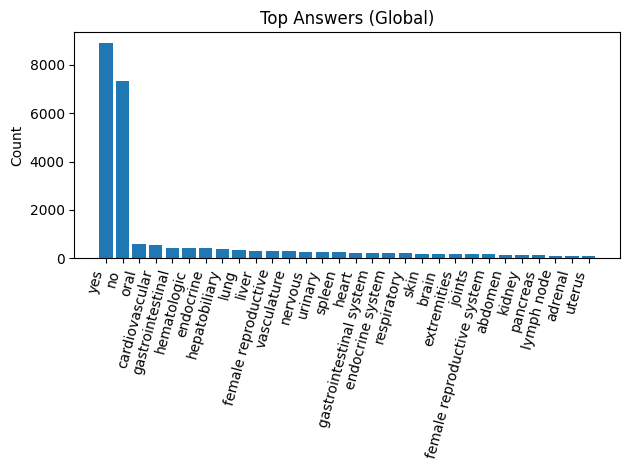

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/answer_coverage_curve_global.png


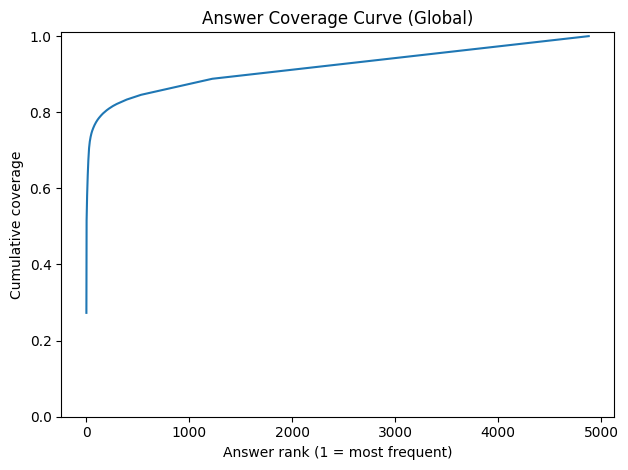


Unique answers (train): 3225


,k,coverage
0,1,0.273634
1,5,0.544164
2,10,0.599776
3,20,0.673196
4,50,0.743665
5,100,0.775974
6,200,0.806604
7,500,0.847003
8,1000,0.886791


Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/top_answers_train_top25.png


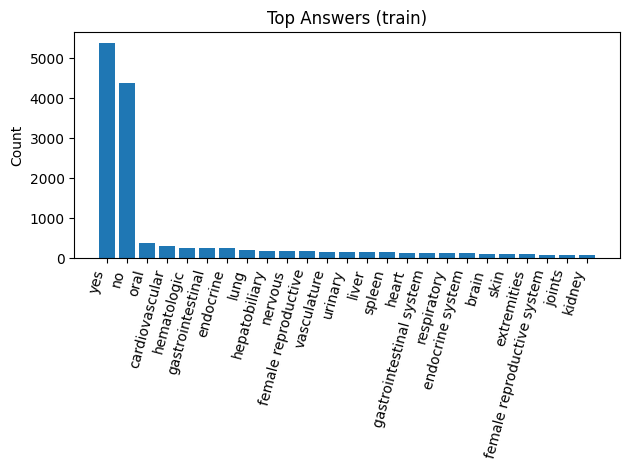

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/answer_coverage_curve_train.png


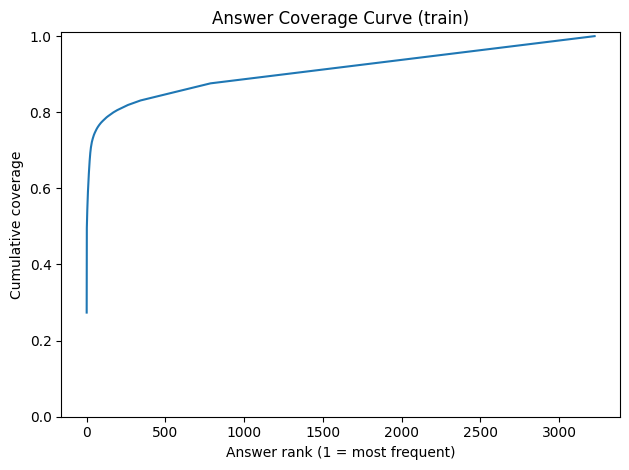


Unique answers (validation): 1215


,k,coverage
0,1,0.273526
1,5,0.549609
2,10,0.608244
3,20,0.681419
4,50,0.754434
5,100,0.790542
6,200,0.826170
7,500,0.885764
8,1000,0.965649


Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/top_answers_validation_top25.png


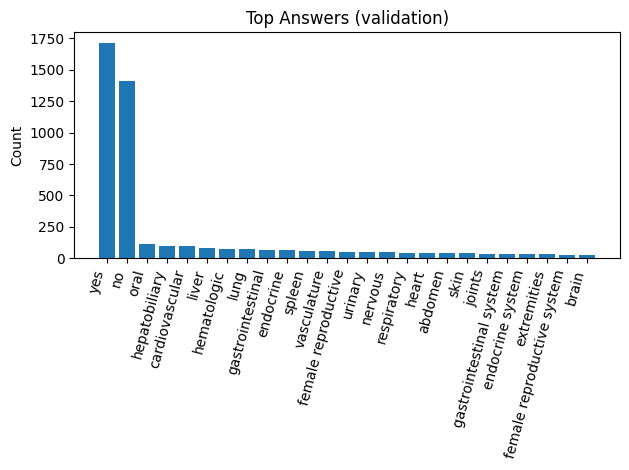

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/answer_coverage_curve_validation.png


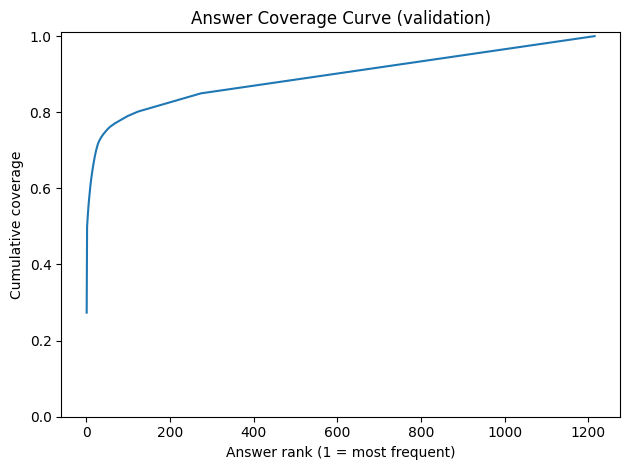


Unique answers (test): 1300


,k,coverage
0,1,0.270278
1,5,0.546956
2,10,0.602768
3,20,0.672273
4,50,0.747135
5,100,0.783599
6,200,0.819318
7,500,0.880935
8,1000,0.955350


Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/top_answers_test_top25.png


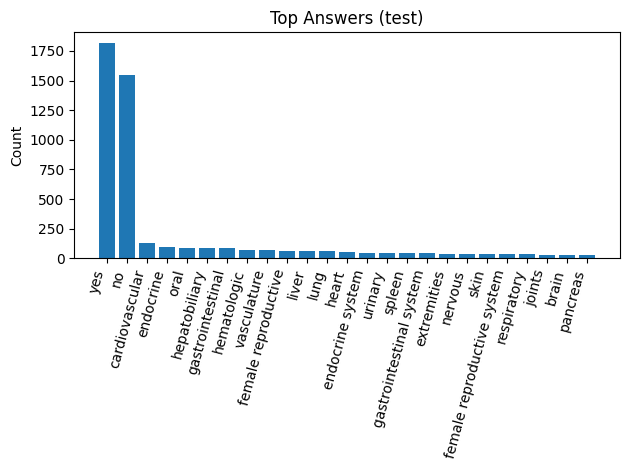

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/answer_coverage_curve_test.png


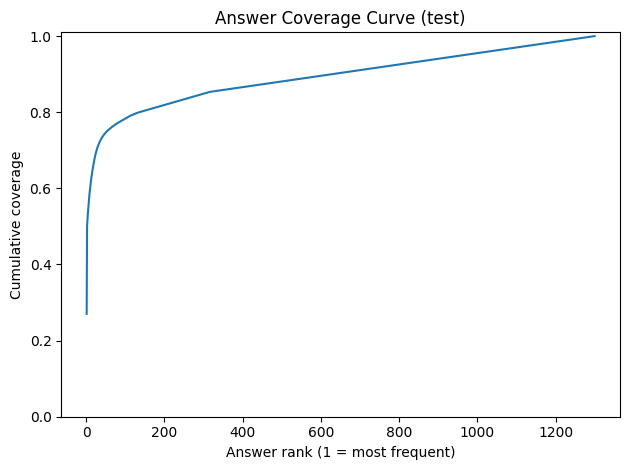

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/answer_type_composition_global.png


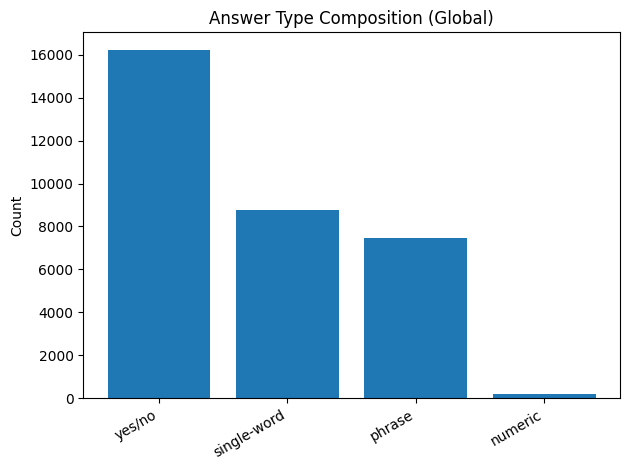

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/answer_type_composition_train.png


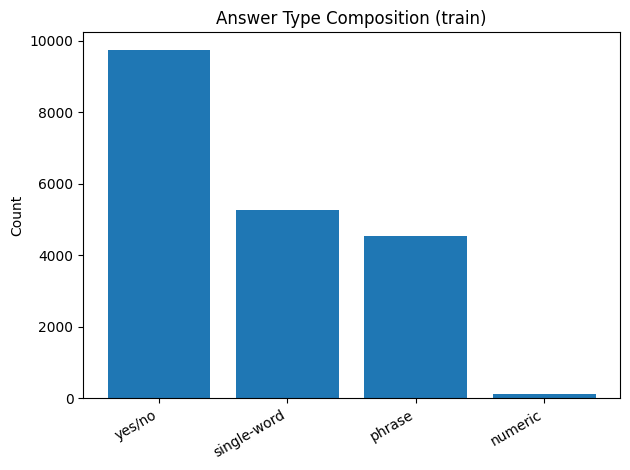

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/answer_type_composition_validation.png


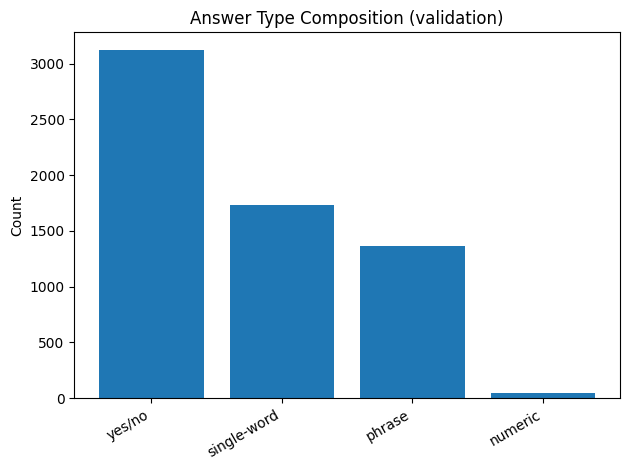

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/answer_type_composition_test.png


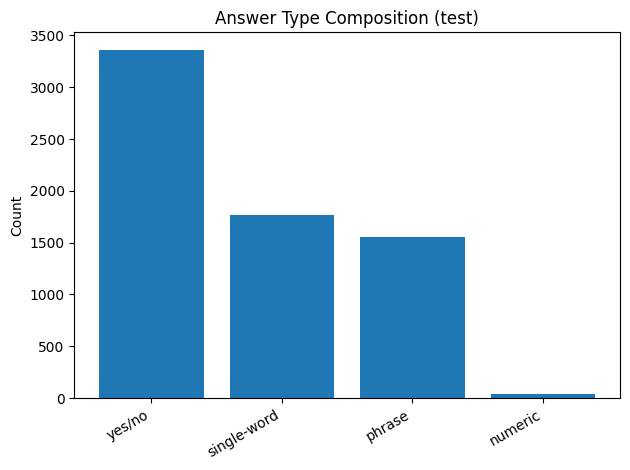

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/yesno_breakdown_global.png


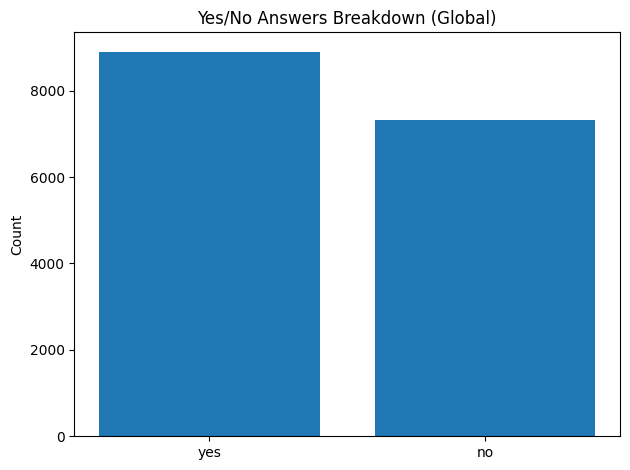

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_question_len_words_global.png


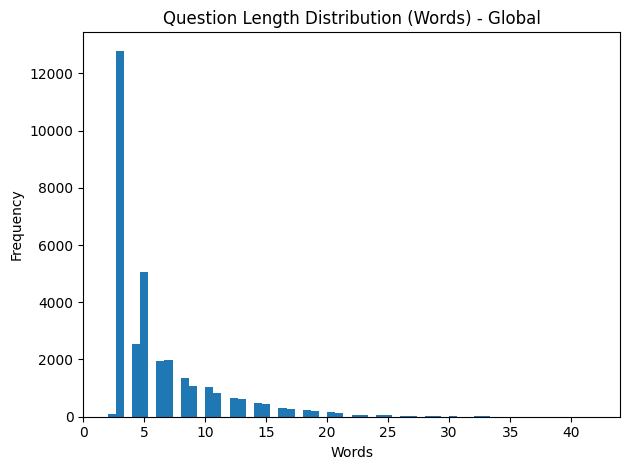

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_answer_len_words_global.png


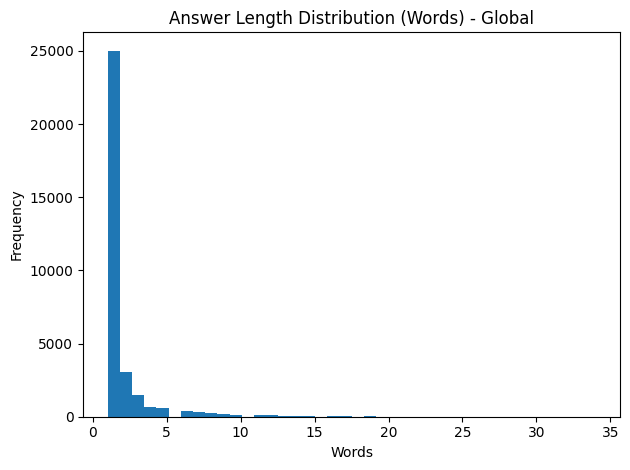

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_question_len_chars_global.png


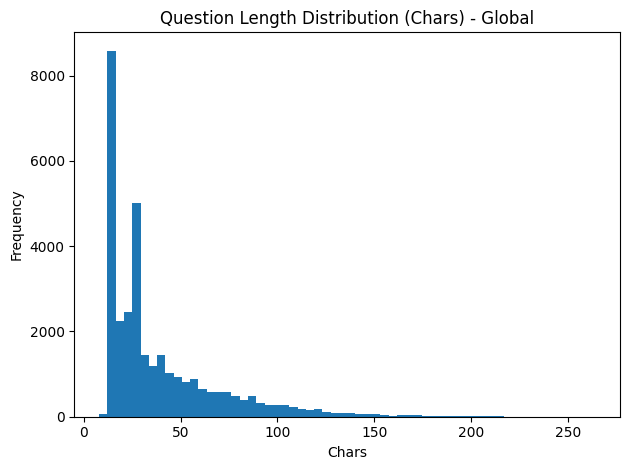

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_answer_len_chars_global.png


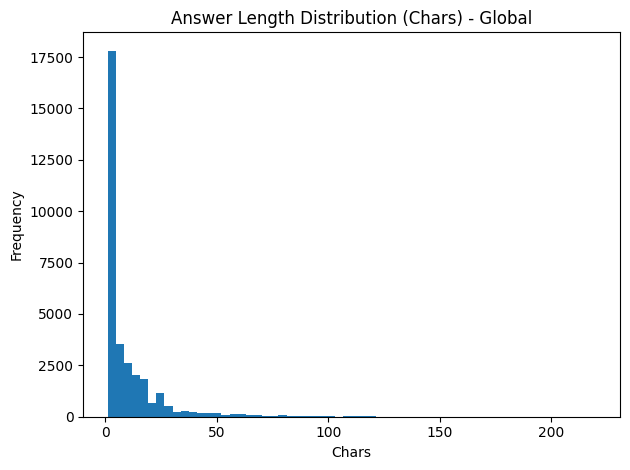

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_question_len_words_train.png


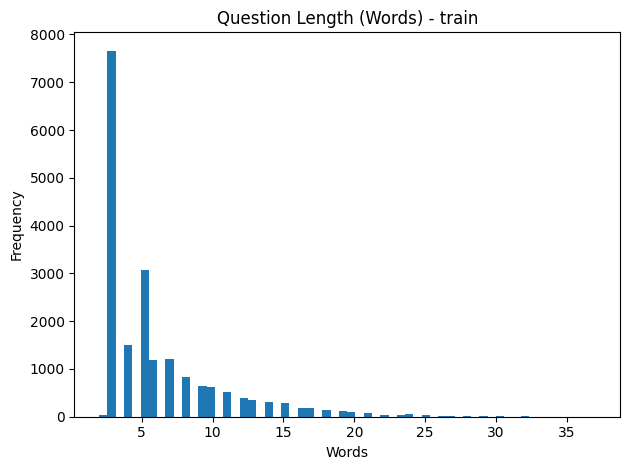

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_answer_len_words_train.png


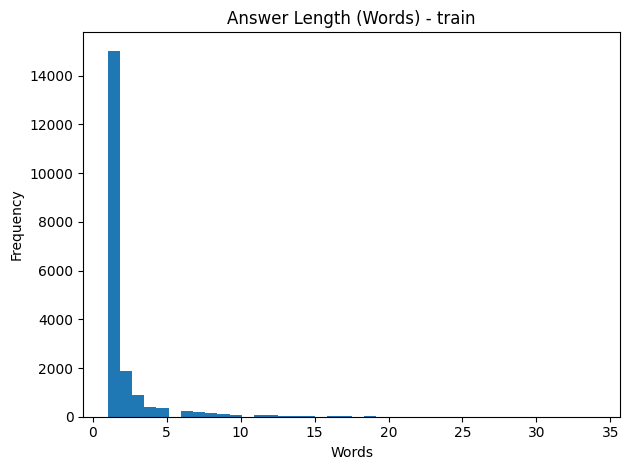

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_question_len_words_validation.png


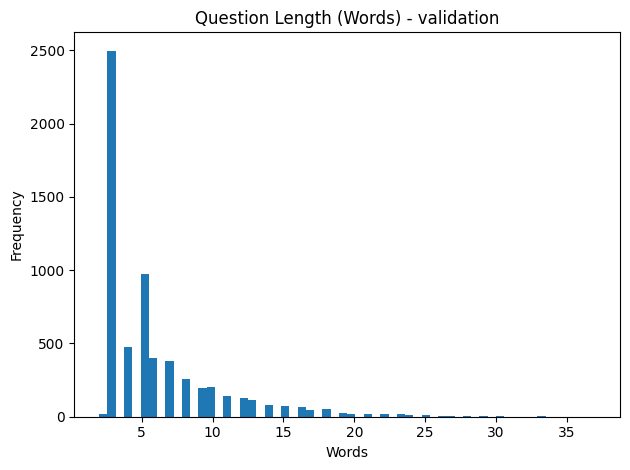

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_answer_len_words_validation.png


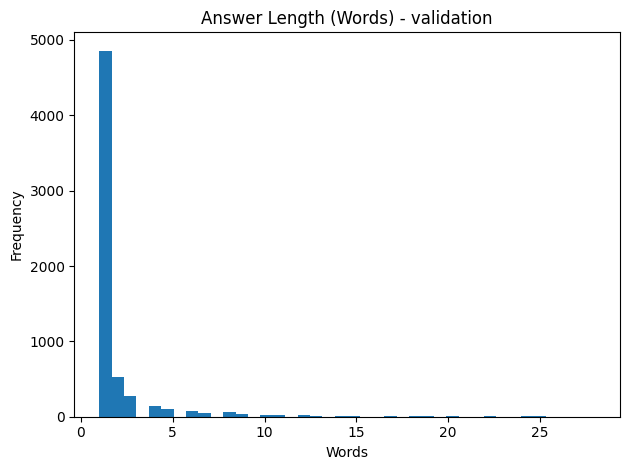

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_question_len_words_test.png


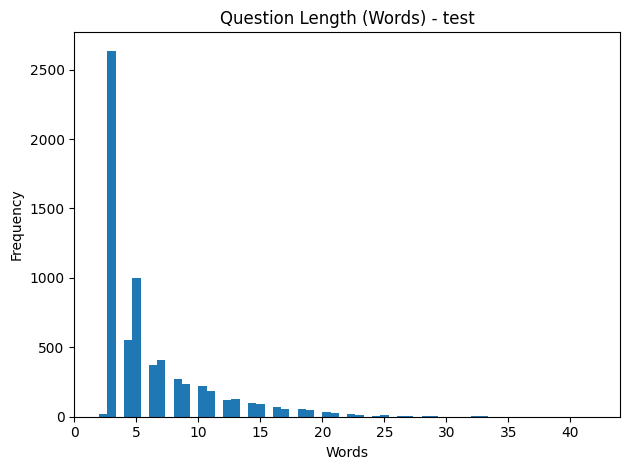

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_answer_len_words_test.png


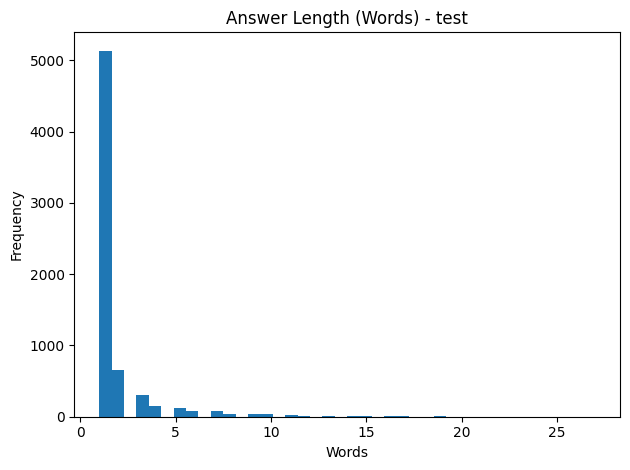


Numeric answers count (global): 197 (0.604%)
Numeric parsed values: 197
  min: -99.0
  median: 19.0
  mean: 173.23857868020303
  p95: 235.9999999999934
  max: 7182.0
Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_numeric_answer_values_global.png


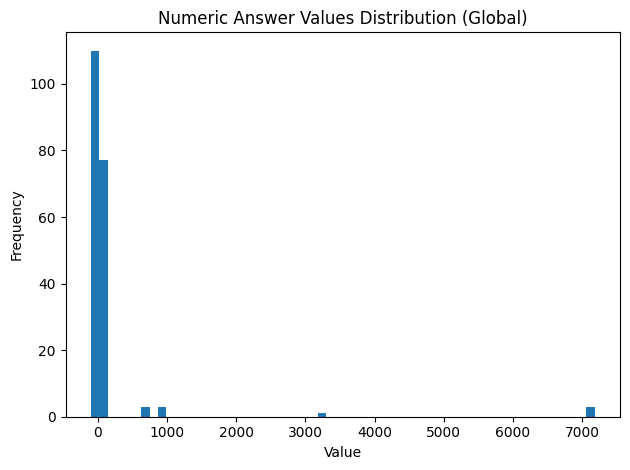


Split overlap (questions):


,col,split_a,split_b,unique_a,unique_b,intersection,jaccard
0,question_norm,test,train,2913,7461,783,0.081639
1,question_norm,test,validation,2913,2713,464,0.089888
2,question_norm,train,validation,7461,2713,745,0.079012



Split overlap (answers):


,col,split_a,split_b,unique_a,unique_b,intersection,jaccard
0,answer_norm,test,train,1300,3225,424,0.103389
1,answer_norm,test,validation,1300,1215,233,0.102103
2,answer_norm,train,validation,3225,1215,401,0.099282


Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/split_overlap_questions.csv
Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/split_overlap_answers.csv
Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/overlap_questions_jaccard.png


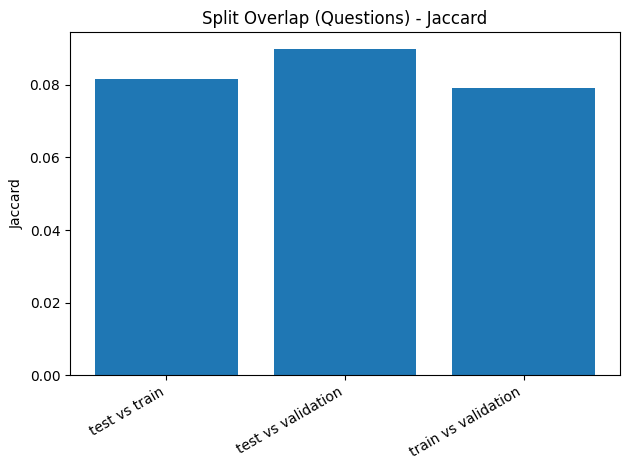

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/overlap_answers_jaccard.png


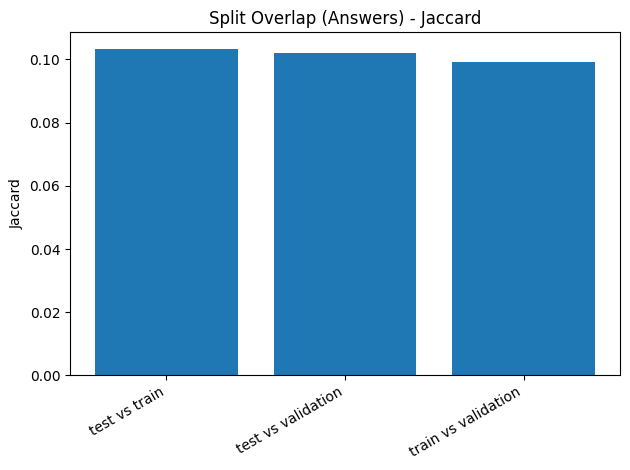

/scr/user/baraahm/Cake/.venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train: sampled 1200 images, failures=0 (0.000%)
validation: sampled 1200 images, failures=0 (0.000%)
test: sampled 1200 images, failures=0 (0.000%)
Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/eda_image_sample_stats.csv


,split,idx,width,height,aspect,mode,ok
0,train,19285,792,528,1.500000,RGB,1
1,train,15126,792,522,1.517241,RGB,1
2,train,13729,792,527,1.502846,RGB,1
3,train,8535,1002,321,3.121495,RGB,1
4,train,9120,792,531,1.491525,RGB,1


Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/img_mode_distribution_sampled.png


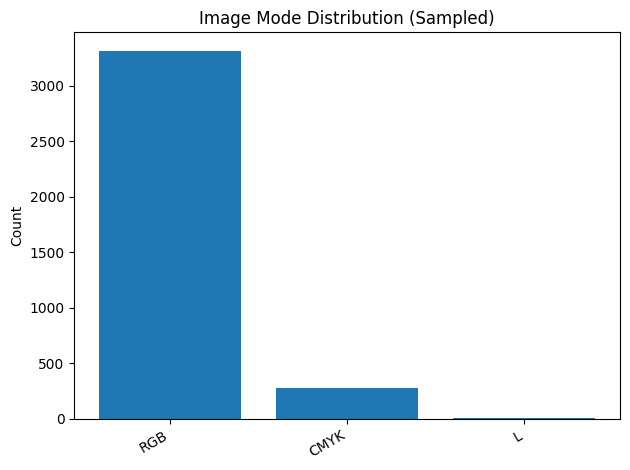

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_img_width_sampled.png


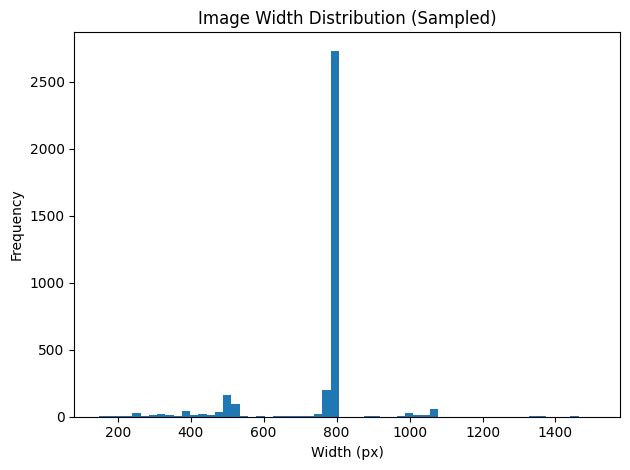

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_img_height_sampled.png


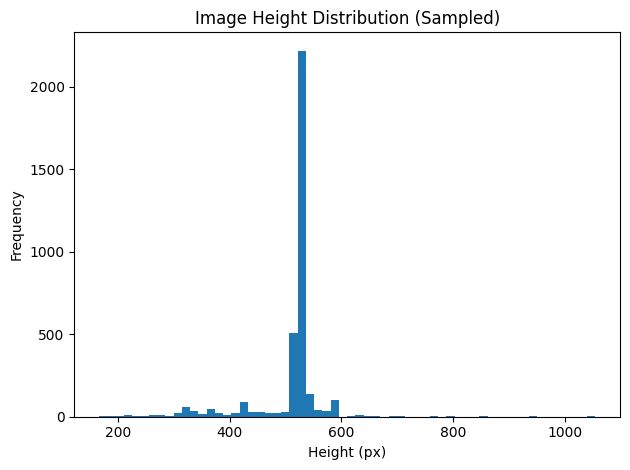

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/hist_img_aspect_sampled.png


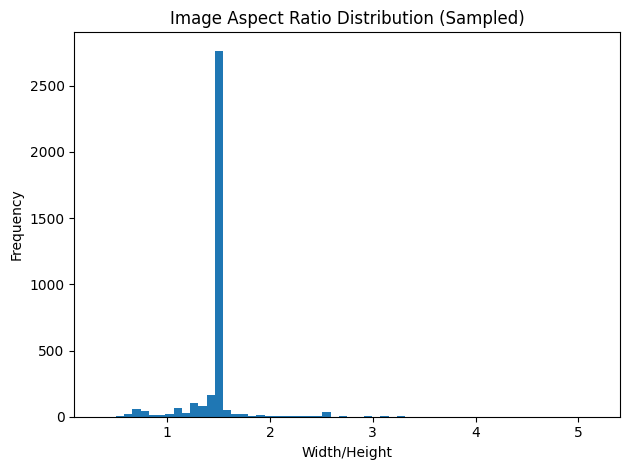

,split,n,width_min,width_med,width_p95,width_max,height_min,height_med,height_p95,height_max,aspect_med
0,test,1200,188,792.0,792.0,1462,186,528.0,568.05,905,1.5
1,train,1200,149,792.0,792.0,1077,166,528.0,566.05,1025,1.5
2,validation,1200,232,792.0,792.0,1509,173,528.0,577.00,1055,1.5


Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/image_resolution_summary_by_split_sampled.csv

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa/eda_report_summary.json
EDA done. All plots were shown inline and saved under: /scr/user/baraahm/Cake/AML/eda_out/path_vqa


In [1]:
# =========================================================
# Path-VQA EDA (detailed, reliable, Jupyter-friendly)
# - Loads the Arrow-based dataset saved by save_to_disk()
# - Computes key dataset stats + "coverage" (answer long-tail)
# - Produces many matplotlib plots (shown in notebook + saved to disk)
# NOTE:
#   1) No argparse. Run as a single notebook cell (or multiple cells).
#   2) Uses matplotlib only (no seaborn). No manual color settings.
# =========================================================

import math
import re
import json
import statistics
from collections import Counter, defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_from_disk
from datasets import Image as HFImage


# =========================================================
# 0) Paths and load dataset (Arrow format)
# =========================================================
ROOT = Path.cwd()
ARROW_DIR = ROOT / "data" / "hf_datasets" / "flaviagiammarino__path-vqa_arrow"
OUT_DIR = ROOT / "eda_out" / "path_vqa"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("ARROW_DIR:", ARROW_DIR)
print("OUT_DIR:", OUT_DIR)

ds = load_from_disk(str(ARROW_DIR))
print("\nLoaded DatasetDict:")
print(ds)


# =========================================================
# 1) Helpers: normalization and simple typing
# =========================================================
def normalize_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s).strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

def is_yes_no(ans_norm: str) -> bool:
    return ans_norm in {"yes", "no"}

def parse_numeric(ans_norm: str):
    # Extract a simple numeric value if present (e.g., "3", "3.5", "2 cm" -> 2)
    m = re.search(r"[-+]?\d*\.?\d+", ans_norm)
    if not m:
        return None
    try:
        return float(m.group(0))
    except Exception:
        return None

def answer_coarse_type(ans_norm: str) -> str:
    if ans_norm == "":
        return "empty"
    if is_yes_no(ans_norm):
        return "yes/no"
    if parse_numeric(ans_norm) is not None:
        return "numeric"
    # Heuristic "short token" vs "phrase"
    if len(ans_norm.split()) == 1:
        return "single-word"
    return "phrase"

def safe_median(values):
    values = [v for v in values if v is not None and not (isinstance(v, float) and math.isnan(v))]
    if not values:
        return None
    return float(np.median(values))

def safe_mean(values):
    values = [v for v in values if v is not None and not (isinstance(v, float) and math.isnan(v))]
    if not values:
        return None
    return float(np.mean(values))

def savefig(fig, name: str):
    path = OUT_DIR / name
    fig.savefig(path, dpi=200, bbox_inches="tight")
    print("Saved:", path)


# =========================================================
# 2) Build a tabular view (text-only) for fast EDA
#    - Avoid converting images to pandas to reduce memory pressure
# =========================================================
def dataset_to_text_df(split_ds, split_name: str) -> pd.DataFrame:
    # Extract only question/answer (fast and safe)
    q = split_ds["question"]
    a = split_ds["answer"]
    df = pd.DataFrame({"split": split_name, "question": q, "answer": a})
    df["question_norm"] = df["question"].map(normalize_text)
    df["answer_norm"] = df["answer"].map(normalize_text)

    df["question_len_chars"] = df["question_norm"].map(len)
    df["answer_len_chars"] = df["answer_norm"].map(len)

    df["question_len_words"] = df["question_norm"].map(lambda x: 0 if x == "" else len(x.split()))
    df["answer_len_words"] = df["answer_norm"].map(lambda x: 0 if x == "" else len(x.split()))

    df["answer_type"] = df["answer_norm"].map(answer_coarse_type)
    df["answer_numeric"] = df["answer_norm"].map(parse_numeric)
    df["is_yesno"] = df["answer_norm"].map(is_yes_no)
    return df

text_dfs = []
for split in ds.keys():
    text_dfs.append(dataset_to_text_df(ds[split], split))
df = pd.concat(text_dfs, ignore_index=True)

print("\nText table preview:")
display(df.head(5))

# Save key tables
df.to_csv(OUT_DIR / "eda_text_table.csv", index=False)
print("Saved:", OUT_DIR / "eda_text_table.csv")


# =========================================================
# 3) Global dataset overview and basic sanity checks
# =========================================================
def print_overview(df: pd.DataFrame):
    print("\n=========================")
    print("Dataset Overview (Text)")
    print("=========================")
    print("Total rows:", len(df))
    print("Rows per split:")
    print(df["split"].value_counts().to_string())

    # Empty fields
    empty_q = (df["question_norm"] == "").sum()
    empty_a = (df["answer_norm"] == "").sum()
    print("\nEmpty question count:", empty_q, f"({empty_q/len(df)*100:.3f}%)")
    print("Empty answer count:", empty_a, f"({empty_a/len(df)*100:.3f}%)")

    # Duplicates (text-only)
    dup_qa = df.duplicated(subset=["question_norm", "answer_norm"]).sum()
    dup_q = df.duplicated(subset=["question_norm"]).sum()
    print("\nDuplicate question+answer pairs:", dup_qa, f"({dup_qa/len(df)*100:.3f}%)")
    print("Duplicate questions (ignoring answers):", dup_q, f"({dup_q/len(df)*100:.3f}%)")

    # Length stats
    for col in ["question_len_words", "answer_len_words", "question_len_chars", "answer_len_chars"]:
        vals = df[col].values
        print(f"\n{col}:")
        print("  min:", int(np.min(vals)))
        print("  median:", float(np.median(vals)))
        print("  mean:", float(np.mean(vals)))
        print("  p95:", float(np.percentile(vals, 95)))
        print("  max:", int(np.max(vals)))

print_overview(df)


# =========================================================
# 4) Answer coverage (long-tail) and distribution
#    - Coverage here means: how much of the dataset is covered by top-K answers
# =========================================================
def compute_answer_freq(df: pd.DataFrame, split: str = None) -> Counter:
    sub = df if split is None else df[df["split"] == split]
    return Counter(sub["answer_norm"].tolist())

def plot_top_answers(freq: Counter, title: str, top_n: int = 30, fname: str = "top_answers.png"):
    items = freq.most_common(top_n)
    labels = [k for k, _ in items]
    counts = [v for _, v in items]

    fig = plt.figure()
    plt.bar(range(len(labels)), counts)
    plt.xticks(range(len(labels)), labels, rotation=75, ha="right")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    savefig(fig, fname)
    plt.show()

def plot_coverage_curve(freq: Counter, title: str, fname: str):
    counts = np.array(sorted(freq.values(), reverse=True), dtype=np.float64)
    total = counts.sum()
    if total <= 0:
        print("No counts to plot for coverage.")
        return

    cum = np.cumsum(counts) / total
    ranks = np.arange(1, len(counts) + 1)

    fig = plt.figure()
    plt.plot(ranks, cum)
    plt.xlabel("Answer rank (1 = most frequent)")
    plt.ylabel("Cumulative coverage")
    plt.title(title)
    plt.ylim(0, 1.01)
    plt.tight_layout()
    savefig(fig, fname)
    plt.show()

def coverage_at_k(freq: Counter, ks=(1, 5, 10, 20, 50, 100, 200, 500, 1000)) -> pd.DataFrame:
    counts = np.array(sorted(freq.values(), reverse=True), dtype=np.float64)
    total = counts.sum()
    rows = []
    for k in ks:
        k2 = min(k, len(counts))
        cov = float(counts[:k2].sum() / total) if total > 0 else 0.0
        rows.append({"k": k, "coverage": cov})
    return pd.DataFrame(rows)

# Global
freq_all = compute_answer_freq(df)
print("\nUnique answers (global):", len(freq_all))

cov_all = coverage_at_k(freq_all)
display(cov_all)
cov_all.to_csv(OUT_DIR / "answer_coverage_global.csv", index=False)
print("Saved:", OUT_DIR / "answer_coverage_global.csv")

plot_top_answers(freq_all, "Top Answers (Global)", top_n=30, fname="top_answers_global_top30.png")
plot_coverage_curve(freq_all, "Answer Coverage Curve (Global)", fname="answer_coverage_curve_global.png")

# Per split
for split in ds.keys():
    freq_s = compute_answer_freq(df, split=split)
    print(f"\nUnique answers ({split}):", len(freq_s))
    cov_s = coverage_at_k(freq_s)
    display(cov_s)
    cov_s.to_csv(OUT_DIR / f"answer_coverage_{split}.csv", index=False)
    plot_top_answers(freq_s, f"Top Answers ({split})", top_n=25, fname=f"top_answers_{split}_top25.png")
    plot_coverage_curve(freq_s, f"Answer Coverage Curve ({split})", fname=f"answer_coverage_curve_{split}.png")


# =========================================================
# 5) Answer type composition (global and per split)
# =========================================================
def plot_answer_type_bar(df: pd.DataFrame, title: str, fname: str):
    vc = df["answer_type"].value_counts()
    fig = plt.figure()
    plt.bar(vc.index.tolist(), vc.values.tolist())
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    savefig(fig, fname)
    plt.show()

plot_answer_type_bar(df, "Answer Type Composition (Global)", "answer_type_composition_global.png")

for split in ds.keys():
    plot_answer_type_bar(df[df["split"] == split], f"Answer Type Composition ({split})", f"answer_type_composition_{split}.png")

# Yes/No breakdown
def plot_yesno_breakdown(df: pd.DataFrame, title: str, fname: str):
    sub = df[df["answer_type"] == "yes/no"]
    vc = sub["answer_norm"].value_counts()
    fig = plt.figure()
    plt.bar(vc.index.tolist(), vc.values.tolist())
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    savefig(fig, fname)
    plt.show()

plot_yesno_breakdown(df, "Yes/No Answers Breakdown (Global)", "yesno_breakdown_global.png")


# =========================================================
# 6) Question and answer length distributions
#    - Separate plots (no subplots)
# =========================================================
def plot_hist(series: pd.Series, title: str, xlabel: str, fname: str, bins: int = 50):
    fig = plt.figure()
    plt.hist(series.values, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.tight_layout()
    savefig(fig, fname)
    plt.show()

plot_hist(df["question_len_words"], "Question Length Distribution (Words) - Global", "Words", "hist_question_len_words_global.png", bins=60)
plot_hist(df["answer_len_words"], "Answer Length Distribution (Words) - Global", "Words", "hist_answer_len_words_global.png", bins=40)
plot_hist(df["question_len_chars"], "Question Length Distribution (Chars) - Global", "Chars", "hist_question_len_chars_global.png", bins=60)
plot_hist(df["answer_len_chars"], "Answer Length Distribution (Chars) - Global", "Chars", "hist_answer_len_chars_global.png", bins=60)

# Per split lengths
for split in ds.keys():
    sub = df[df["split"] == split]
    plot_hist(sub["question_len_words"], f"Question Length (Words) - {split}", "Words", f"hist_question_len_words_{split}.png", bins=60)
    plot_hist(sub["answer_len_words"], f"Answer Length (Words) - {split}", "Words", f"hist_answer_len_words_{split}.png", bins=40)


# =========================================================
# 7) Numeric answers analysis (if present)
# =========================================================
num_df = df[df["answer_type"] == "numeric"].copy()
print("\nNumeric answers count (global):", len(num_df), f"({len(num_df)/len(df)*100:.3f}%)")

if len(num_df) > 0:
    valid_nums = num_df["answer_numeric"].dropna().values
    print("Numeric parsed values:", len(valid_nums))
    print("  min:", float(np.min(valid_nums)))
    print("  median:", float(np.median(valid_nums)))
    print("  mean:", float(np.mean(valid_nums)))
    print("  p95:", float(np.percentile(valid_nums, 95)))
    print("  max:", float(np.max(valid_nums)))

    fig = plt.figure()
    plt.hist(valid_nums, bins=60)
    plt.title("Numeric Answer Values Distribution (Global)")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    savefig(fig, "hist_numeric_answer_values_global.png")
    plt.show()


# =========================================================
# 8) Split overlap checks (answers and questions)
#    - Useful for leakage risk assessment
# =========================================================
def split_overlap_report(df: pd.DataFrame, col: str) -> pd.DataFrame:
    splits = sorted(df["split"].unique())
    sets = {s: set(df[df["split"] == s][col].tolist()) for s in splits}
    rows = []
    for i in range(len(splits)):
        for j in range(i + 1, len(splits)):
            a, b = splits[i], splits[j]
            inter = sets[a].intersection(sets[b])
            rows.append({
                "col": col,
                "split_a": a,
                "split_b": b,
                "unique_a": len(sets[a]),
                "unique_b": len(sets[b]),
                "intersection": len(inter),
                "jaccard": (len(inter) / (len(sets[a].union(sets[b])) + 1e-12)),
            })
    return pd.DataFrame(rows)

over_q = split_overlap_report(df, "question_norm")
over_a = split_overlap_report(df, "answer_norm")

print("\nSplit overlap (questions):")
display(over_q)
print("\nSplit overlap (answers):")
display(over_a)

over_q.to_csv(OUT_DIR / "split_overlap_questions.csv", index=False)
over_a.to_csv(OUT_DIR / "split_overlap_answers.csv", index=False)
print("Saved:", OUT_DIR / "split_overlap_questions.csv")
print("Saved:", OUT_DIR / "split_overlap_answers.csv")

# Plot jaccard overlaps
def plot_overlap_jaccard(over_df: pd.DataFrame, title: str, fname: str):
    labels = [f"{r.split_a} vs {r.split_b}" for _, r in over_df.iterrows()]
    vals = over_df["jaccard"].values

    fig = plt.figure()
    plt.bar(range(len(labels)), vals)
    plt.xticks(range(len(labels)), labels, rotation=30, ha="right")
    plt.ylabel("Jaccard")
    plt.title(title)
    plt.tight_layout()
    savefig(fig, fname)
    plt.show()

plot_overlap_jaccard(over_q, "Split Overlap (Questions) - Jaccard", "overlap_questions_jaccard.png")
plot_overlap_jaccard(over_a, "Split Overlap (Answers) - Jaccard", "overlap_answers_jaccard.png")


# =========================================================
# 9) Image EDA (resolution, mode, aspect ratio, load failures)
#    - Image decoding over all rows can be slow; control with sample sizes
# =========================================================
IMAGE_SAMPLE_PER_SPLIT = 1200   
RNG_SEED = 42

def sample_indices(n: int, k: int, seed: int) -> np.ndarray:
    rng = np.random.default_rng(seed)
    k2 = min(k, n)
    return rng.choice(n, size=k2, replace=False)

def image_stats_for_split(split_ds, split_name: str, sample_k: int) -> pd.DataFrame:
    # Use decode=True for PIL-based stats; for speed, sample only
    n = split_ds.num_rows
    idx = sample_indices(n, sample_k, seed=RNG_SEED + hash(split_name) % 10000)
    rows = []
    fail = 0

    for i in idx:
        try:
            img = split_ds[i]["image"]  # PIL Image (usually)
            w, h = img.size
            mode = getattr(img, "mode", None)
            rows.append({
                "split": split_name,
                "idx": int(i),
                "width": int(w),
                "height": int(h),
                "aspect": float(w / (h + 1e-12)),
                "mode": str(mode) if mode is not None else "unknown",
                "ok": 1
            })
        except Exception:
            fail += 1
            rows.append({
                "split": split_name,
                "idx": int(i),
                "width": None,
                "height": None,
                "aspect": None,
                "mode": "error",
                "ok": 0
            })

    out = pd.DataFrame(rows)
    print(f"{split_name}: sampled {len(out)} images, failures={fail} ({fail/len(out)*100:.3f}%)")
    return out

img_dfs = []
for split in ds.keys():
    img_dfs.append(image_stats_for_split(ds[split], split, IMAGE_SAMPLE_PER_SPLIT))

img_df = pd.concat(img_dfs, ignore_index=True)
img_df.to_csv(OUT_DIR / "eda_image_sample_stats.csv", index=False)
print("Saved:", OUT_DIR / "eda_image_sample_stats.csv")
display(img_df.head(5))

# Image mode distribution
def plot_mode_distribution(img_df: pd.DataFrame, title: str, fname: str):
    vc = img_df["mode"].value_counts()
    fig = plt.figure()
    plt.bar(vc.index.tolist(), vc.values.tolist())
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    savefig(fig, fname)
    plt.show()

plot_mode_distribution(img_df, "Image Mode Distribution (Sampled)", "img_mode_distribution_sampled.png")

# Resolution distributions
ok_img = img_df[img_df["ok"] == 1].copy()
if len(ok_img) > 0:
    plot_hist(ok_img["width"].dropna(), "Image Width Distribution (Sampled)", "Width (px)", "hist_img_width_sampled.png", bins=60)
    plot_hist(ok_img["height"].dropna(), "Image Height Distribution (Sampled)", "Height (px)", "hist_img_height_sampled.png", bins=60)
    plot_hist(ok_img["aspect"].dropna(), "Image Aspect Ratio Distribution (Sampled)", "Width/Height", "hist_img_aspect_sampled.png", bins=60)

    # Per split resolution summary
    summary = ok_img.groupby("split").agg(
        n=("ok", "count"),
        width_min=("width", "min"),
        width_med=("width", "median"),
        width_p95=("width", lambda x: float(np.percentile(x, 95))),
        width_max=("width", "max"),
        height_min=("height", "min"),
        height_med=("height", "median"),
        height_p95=("height", lambda x: float(np.percentile(x, 95))),
        height_max=("height", "max"),
        aspect_med=("aspect", "median"),
    ).reset_index()

    display(summary)
    summary.to_csv(OUT_DIR / "image_resolution_summary_by_split_sampled.csv", index=False)
    print("Saved:", OUT_DIR / "image_resolution_summary_by_split_sampled.csv")


# =========================================================
# 10) Export a compact "EDA report JSON" for quick reuse
# =========================================================
report = {}

report["rows_per_split"] = df["split"].value_counts().to_dict()
report["empty_question_pct"] = float((df["question_norm"] == "").mean() * 100.0)
report["empty_answer_pct"] = float((df["answer_norm"] == "").mean() * 100.0)

report["unique_answers_global"] = int(len(freq_all))
report["answer_coverage_global"] = {int(r.k): float(r.coverage) for r in cov_all.itertuples(index=False)}

report["answer_type_counts_global"] = df["answer_type"].value_counts().to_dict()
report["yesno_counts_global"] = df[df["answer_type"] == "yes/no"]["answer_norm"].value_counts().to_dict()

report["length_stats_global"] = {
    "question_len_words": {
        "min": int(df["question_len_words"].min()),
        "median": float(df["question_len_words"].median()),
        "mean": float(df["question_len_words"].mean()),
        "p95": float(np.percentile(df["question_len_words"], 95)),
        "max": int(df["question_len_words"].max()),
    },
    "answer_len_words": {
        "min": int(df["answer_len_words"].min()),
        "median": float(df["answer_len_words"].median()),
        "mean": float(df["answer_len_words"].mean()),
        "p95": float(np.percentile(df["answer_len_words"], 95)),
        "max": int(df["answer_len_words"].max()),
    },
}

# Image sample failure rate per split
if len(img_df) > 0:
    fail_by_split = img_df.groupby("split")["ok"].apply(lambda x: float((1 - x.mean()) * 100.0)).to_dict()
    report["image_sample_failure_pct_by_split"] = fail_by_split
    report["image_mode_counts_sampled"] = img_df["mode"].value_counts().to_dict()

with open(OUT_DIR / "eda_report_summary.json", "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2)

print("\nSaved:", OUT_DIR / "eda_report_summary.json")
print("EDA done. All plots were shown inline and saved under:", OUT_DIR)

### Text-Only EDA for PATH-VQA (No Plots)

This cell runs a **fully text-based Exploratory Data Analysis** on the Arrow-formatted PATH-VQA dataset:  
- Loads the dataset from disk and constructs a **text-only dataframe** (questions & answers) for memory-efficient analysis;  
- Prints **global and split-wise statistics** directly to the console (sizes, empties, duplicates, length stats);  
- Computes **answer frequency, long-tail coverage, and top answers** without visualization;  
- Reports **answer type composition** (yes/no, numeric, single-word, phrases) with counts and percentages;  
- Analyzes **numeric answers** and summarizes parsed value statistics;  
- Checks **split overlap (Jaccard)** for questions and answers to assess leakage risk;  
- Performs **sampled image diagnostics** (decode failures, mode, resolution, aspect ratio) with printed summaries;  
- Exports CSV tables and a **compact JSON report** for downstream reuse.

**Goal:** provide a **fast, reliable, plot-free EDA** suitable for terminals, logs, or headless environments.

In [2]:
# =========================================================
# Path-VQA EDA (text-only, reliable, terminal/Jupyter prints)
# - Loads the Arrow-based dataset saved by save_to_disk()
# - Computes all key EDA stats that were previously plotted
# - Prints numeric/text summaries directly (no plots)
# - Optionally saves CSV/JSON summaries for later use
# =========================================================

import math
import re
import json
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd

from datasets import load_from_disk


# =========================================================
# 0) Config
# =========================================================
ROOT = Path.cwd()
ARROW_DIR = ROOT / "data" / "hf_datasets" / "flaviagiammarino__path-vqa_arrow"
OUT_DIR = ROOT / "eda_out" / "path_vqa_text"
OUT_DIR.mkdir(parents=True, exist_ok=True)

TOP_N_ANSWERS = 30
COVERAGE_KS = (1, 5, 10, 20, 50, 100, 200, 500, 1000)
IMAGE_SAMPLE_PER_SPLIT = 1200
RNG_SEED = 42

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 160)

print("ROOT:", ROOT)
print("ARROW_DIR:", ARROW_DIR)
print("OUT_DIR:", OUT_DIR)


# =========================================================
# 1) Load dataset
# =========================================================
ds = load_from_disk(str(ARROW_DIR))
print("\nLoaded DatasetDict:")
print(ds)


# =========================================================
# 2) Helpers
# =========================================================
def normalize_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s).strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

def is_yes_no(ans_norm: str) -> bool:
    return ans_norm in {"yes", "no"}

def parse_numeric(ans_norm: str):
    m = re.search(r"[-+]?\d*\.?\d+", ans_norm)
    if not m:
        return None
    try:
        return float(m.group(0))
    except Exception:
        return None

def answer_coarse_type(ans_norm: str) -> str:
    if ans_norm == "":
        return "empty"
    if is_yes_no(ans_norm):
        return "yes/no"
    if parse_numeric(ans_norm) is not None:
        return "numeric"
    if len(ans_norm.split()) == 1:
        return "single-word"
    return "phrase"

def pct(x, denom):
    return 0.0 if denom == 0 else (x / denom * 100.0)

def df_print(title: str, df_: pd.DataFrame, max_rows: int = 50):
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)
    if len(df_) <= max_rows:
        print(df_.to_string(index=False))
    else:
        print(df_.head(max_rows).to_string(index=False))
        print(f"... (showing first {max_rows} rows of {len(df_)})")

def describe_int_series(name: str, arr: np.ndarray):
    arr = np.asarray(arr)
    if arr.size == 0:
        return {f"{name}_count": 0}
    return {
        f"{name}_min": int(np.min(arr)),
        f"{name}_median": float(np.median(arr)),
        f"{name}_mean": float(np.mean(arr)),
        f"{name}_p95": float(np.percentile(arr, 95)),
        f"{name}_max": int(np.max(arr)),
    }

def describe_float_series(name: str, arr: np.ndarray):
    arr = np.asarray(arr, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return {f"{name}_count": 0}
    return {
        f"{name}_min": float(np.min(arr)),
        f"{name}_median": float(np.median(arr)),
        f"{name}_mean": float(np.mean(arr)),
        f"{name}_p95": float(np.percentile(arr, 95)),
        f"{name}_max": float(np.max(arr)),
    }

def sample_indices(n: int, k: int, seed: int) -> np.ndarray:
    rng = np.random.default_rng(seed)
    k2 = min(k, n)
    return rng.choice(n, size=k2, replace=False)


# =========================================================
# 3) Build a text-only dataframe (question/answer fields)
# =========================================================
def dataset_to_text_df(split_ds, split_name: str) -> pd.DataFrame:
    q = split_ds["question"]
    a = split_ds["answer"]

    df_ = pd.DataFrame({"split": split_name, "question": q, "answer": a})
    df_["question_norm"] = df_["question"].map(normalize_text)
    df_["answer_norm"] = df_["answer"].map(normalize_text)

    df_["question_len_chars"] = df_["question_norm"].map(len)
    df_["answer_len_chars"] = df_["answer_norm"].map(len)

    df_["question_len_words"] = df_["question_norm"].map(lambda x: 0 if x == "" else len(x.split()))
    df_["answer_len_words"] = df_["answer_norm"].map(lambda x: 0 if x == "" else len(x.split()))

    df_["answer_type"] = df_["answer_norm"].map(answer_coarse_type)
    df_["answer_numeric"] = df_["answer_norm"].map(parse_numeric)
    df_["is_yesno"] = df_["answer_norm"].map(is_yes_no)

    return df_

text_dfs = [dataset_to_text_df(ds[s], s) for s in ds.keys()]
df = pd.concat(text_dfs, ignore_index=True)

df.to_csv(OUT_DIR / "eda_text_table.csv", index=False)
print("\nSaved:", OUT_DIR / "eda_text_table.csv")


# =========================================================
# 4) Dataset overview (prints)
# =========================================================
print("\n" + "=" * 80)
print("DATASET OVERVIEW (TEXT)")
print("=" * 80)

total_rows = len(df)
rows_per_split = df["split"].value_counts().to_dict()

print("Total rows:", total_rows)
print("Rows per split:", rows_per_split)

empty_q = int((df["question_norm"] == "").sum())
empty_a = int((df["answer_norm"] == "").sum())

print(f"Empty questions: {empty_q} ({pct(empty_q, total_rows):.4f}%)")
print(f"Empty answers:   {empty_a} ({pct(empty_a, total_rows):.4f}%)")

dup_qa = int(df.duplicated(subset=["question_norm", "answer_norm"]).sum())
dup_q = int(df.duplicated(subset=["question_norm"]).sum())

print(f"Duplicate (question+answer) pairs: {dup_qa} ({pct(dup_qa, total_rows):.4f}%)")
print(f"Duplicate questions (ignoring answers): {dup_q} ({pct(dup_q, total_rows):.4f}%)")

length_stats = {}
length_stats.update(describe_int_series("question_len_words", df["question_len_words"].values))
length_stats.update(describe_int_series("answer_len_words", df["answer_len_words"].values))
length_stats.update(describe_int_series("question_len_chars", df["question_len_chars"].values))
length_stats.update(describe_int_series("answer_len_chars", df["answer_len_chars"].values))

df_print("Length stats (Global)", pd.DataFrame([length_stats]))


# =========================================================
# 5) Answer frequency, coverage (prints)
# =========================================================
def compute_answer_freq(df_: pd.DataFrame) -> Counter:
    return Counter(df_["answer_norm"].tolist())

def coverage_at_k(freq: Counter, ks) -> pd.DataFrame:
    counts = np.array(sorted(freq.values(), reverse=True), dtype=np.float64)
    total = counts.sum()
    rows = []
    for k in ks:
        k2 = min(k, len(counts))
        cov = float(counts[:k2].sum() / total) if total > 0 else 0.0
        rows.append({"k": int(k), "coverage": cov, "coverage_pct": cov * 100.0})
    return pd.DataFrame(rows)

def top_n_table(freq: Counter, top_n: int) -> pd.DataFrame:
    items = freq.most_common(top_n)
    return pd.DataFrame(items, columns=["answer_norm", "count"])

print("\n" + "=" * 80)
print("ANSWER LONG-TAIL / COVERAGE (GLOBAL)")
print("=" * 80)

freq_all = compute_answer_freq(df)
print("Unique answers (global):", len(freq_all))

cov_all = coverage_at_k(freq_all, COVERAGE_KS)
df_print("Coverage@K (Global)", cov_all, max_rows=200)
cov_all.to_csv(OUT_DIR / "answer_coverage_global.csv", index=False)

top_all = top_n_table(freq_all, TOP_N_ANSWERS)
df_print(f"Top-{TOP_N_ANSWERS} answers (Global)", top_all, max_rows=TOP_N_ANSWERS)
top_all.to_csv(OUT_DIR / "top_answers_global.csv", index=False)

# Per split
for split in ds.keys():
    print("\n" + "=" * 80)
    print(f"ANSWER LONG-TAIL / COVERAGE ({split.upper()})")
    print("=" * 80)

    sub = df[df["split"] == split]
    freq_s = compute_answer_freq(sub)

    print(f"Rows: {len(sub)}")
    print(f"Unique answers ({split}): {len(freq_s)}")

    cov_s = coverage_at_k(freq_s, COVERAGE_KS)
    df_print(f"Coverage@K ({split})", cov_s, max_rows=200)
    cov_s.to_csv(OUT_DIR / f"answer_coverage_{split}.csv", index=False)

    top_s = top_n_table(freq_s, TOP_N_ANSWERS)
    df_print(f"Top-{TOP_N_ANSWERS} answers ({split})", top_s, max_rows=TOP_N_ANSWERS)
    top_s.to_csv(OUT_DIR / f"top_answers_{split}.csv", index=False)


# =========================================================
# 6) Answer type composition (counts + percentages)
# =========================================================
def type_composition_table(sub_df: pd.DataFrame) -> pd.DataFrame:
    vc = sub_df["answer_type"].value_counts()
    out = pd.DataFrame({"answer_type": vc.index, "count": vc.values})
    out["pct"] = out["count"].map(lambda x: pct(x, len(sub_df)))
    return out

print("\n" + "=" * 80)
print("ANSWER TYPE COMPOSITION (GLOBAL)")
print("=" * 80)

type_global = type_composition_table(df)
df_print("Answer type composition (Global)", type_global, max_rows=50)
type_global.to_csv(OUT_DIR / "answer_type_composition_global.csv", index=False)

# Per split
for split in ds.keys():
    print("\n" + "=" * 80)
    print(f"ANSWER TYPE COMPOSITION ({split.upper()})")
    print("=" * 80)
    type_s = type_composition_table(df[df["split"] == split])
    df_print(f"Answer type composition ({split})", type_s, max_rows=50)
    type_s.to_csv(OUT_DIR / f"answer_type_composition_{split}.csv", index=False)

# Yes/No breakdown
yesno_df = df[df["answer_type"] == "yes/no"].copy()
yesno_counts = yesno_df["answer_norm"].value_counts()
yesno_table = pd.DataFrame({"answer": yesno_counts.index, "count": yesno_counts.values})
yesno_table["pct_within_yesno"] = yesno_table["count"].map(lambda x: pct(x, len(yesno_df)))
yesno_table["pct_overall"] = yesno_table["count"].map(lambda x: pct(x, len(df)))

print("\n" + "=" * 80)
print("YES/NO BREAKDOWN (GLOBAL)")
print("=" * 80)
print(f"Total yes/no rows: {len(yesno_df)} ({pct(len(yesno_df), len(df)):.4f}% of all rows)")
df_print("Yes/No counts (Global)", yesno_table, max_rows=10)
yesno_table.to_csv(OUT_DIR / "yesno_breakdown_global.csv", index=False)


# =========================================================
# 7) Numeric answer analysis (prints)
# =========================================================
num_df = df[df["answer_type"] == "numeric"].copy()
print("\n" + "=" * 80)
print("NUMERIC ANSWERS (GLOBAL)")
print("=" * 80)
print(f"Numeric rows: {len(num_df)} ({pct(len(num_df), len(df)):.4f}% of all rows)")

if len(num_df) > 0:
    vals = num_df["answer_numeric"].dropna().values.astype(float)
    stats_num = describe_float_series("numeric_value", vals)
    df_print("Numeric parsed value stats (Global)", pd.DataFrame([stats_num]), max_rows=10)

    # Show a few most common raw numeric answers (as text)
    raw_num_counts = num_df["answer_norm"].value_counts().head(20)
    raw_num_table = pd.DataFrame({"answer_norm": raw_num_counts.index, "count": raw_num_counts.values})
    df_print("Top numeric answer strings (Global)", raw_num_table, max_rows=20)
    raw_num_table.to_csv(OUT_DIR / "top_numeric_answer_strings_global.csv", index=False)


# =========================================================
# 8) Split overlap checks (Jaccard) for questions and answers
# =========================================================
def split_overlap_report(df_: pd.DataFrame, col: str) -> pd.DataFrame:
    splits = sorted(df_["split"].unique())
    sets = {s: set(df_[df_["split"] == s][col].tolist()) for s in splits}
    rows = []
    for i in range(len(splits)):
        for j in range(i + 1, len(splits)):
            a, b = splits[i], splits[j]
            inter = sets[a].intersection(sets[b])
            uni = sets[a].union(sets[b])
            jacc = (len(inter) / (len(uni) + 1e-12))
            rows.append({
                "col": col,
                "split_a": a,
                "split_b": b,
                "unique_a": len(sets[a]),
                "unique_b": len(sets[b]),
                "intersection": len(inter),
                "union": len(uni),
                "jaccard": float(jacc),
                "jaccard_pct": float(jacc * 100.0),
            })
    return pd.DataFrame(rows)

print("\n" + "=" * 80)
print("SPLIT OVERLAP (QUESTIONS) - JACCARD")
print("=" * 80)
over_q = split_overlap_report(df, "question_norm")
df_print("Question overlap (Jaccard)", over_q, max_rows=20)
over_q.to_csv(OUT_DIR / "split_overlap_questions.csv", index=False)

print("\n" + "=" * 80)
print("SPLIT OVERLAP (ANSWERS) - JACCARD")
print("=" * 80)
over_a = split_overlap_report(df, "answer_norm")
df_print("Answer overlap (Jaccard)", over_a, max_rows=20)
over_a.to_csv(OUT_DIR / "split_overlap_answers.csv", index=False)


# =========================================================
# 9) Image EDA (sampled): resolution, mode, aspect ratio, failure rate
# =========================================================
def image_stats_for_split(split_ds, split_name: str, sample_k: int) -> pd.DataFrame:
    n = split_ds.num_rows
    idx = sample_indices(n, sample_k, seed=RNG_SEED + (abs(hash(split_name)) % 10000))
    rows = []
    fail = 0

    for i in idx:
        try:
            img = split_ds[int(i)]["image"]  # typically PIL
            w, h = img.size
            mode = getattr(img, "mode", None)
            rows.append({
                "split": split_name,
                "idx": int(i),
                "width": int(w),
                "height": int(h),
                "aspect": float(w / (h + 1e-12)),
                "mode": str(mode) if mode is not None else "unknown",
                "ok": 1
            })
        except Exception:
            fail += 1
            rows.append({
                "split": split_name,
                "idx": int(i),
                "width": None,
                "height": None,
                "aspect": None,
                "mode": "error",
                "ok": 0
            })

    out = pd.DataFrame(rows)
    print(f"{split_name}: sampled {len(out)} images, failures={fail} ({pct(fail, len(out)):.4f}%)")
    return out

print("\n" + "=" * 80)
print("IMAGE EDA (SAMPLED)")
print("=" * 80)

img_dfs = []
for split in ds.keys():
    img_dfs.append(image_stats_for_split(ds[split], split, IMAGE_SAMPLE_PER_SPLIT))
img_df = pd.concat(img_dfs, ignore_index=True)

img_df.to_csv(OUT_DIR / "eda_image_sample_stats.csv", index=False)
print("Saved:", OUT_DIR / "eda_image_sample_stats.csv")

# Failure rate per split
fail_rate = img_df.groupby("split")["ok"].apply(lambda x: float((1 - x.mean()) * 100.0)).reset_index()
fail_rate.columns = ["split", "failure_pct"]
df_print("Image decode failure rate by split (sampled)", fail_rate, max_rows=20)

# Mode distribution
mode_counts = img_df["mode"].value_counts()
mode_table = pd.DataFrame({"mode": mode_counts.index, "count": mode_counts.values})
mode_table["pct"] = mode_table["count"].map(lambda x: pct(x, len(img_df)))
df_print("Image mode distribution (sampled)", mode_table, max_rows=30)
mode_table.to_csv(OUT_DIR / "image_mode_distribution_sampled.csv", index=False)

# Resolution/aspect summaries (only ok images)
ok_img = img_df[img_df["ok"] == 1].copy()
if len(ok_img) > 0:
    summary_rows = []
    for split in sorted(ok_img["split"].unique()):
        sub = ok_img[ok_img["split"] == split]
        w = sub["width"].dropna().values.astype(int)
        h = sub["height"].dropna().values.astype(int)
        a = sub["aspect"].dropna().values.astype(float)

        row = {"split": split, "n_ok": int(len(sub))}
        row.update(describe_int_series("width", w))
        row.update(describe_int_series("height", h))
        row.update(describe_float_series("aspect", a))
        summary_rows.append(row)

    res_summary = pd.DataFrame(summary_rows)
    df_print("Image resolution/aspect summary by split (sampled)", res_summary, max_rows=20)
    res_summary.to_csv(OUT_DIR / "image_resolution_summary_by_split_sampled.csv", index=False)


# =========================================================
# 10) Export a compact report JSON (all key numeric results)
# =========================================================
report = {}
report["rows_per_split"] = rows_per_split
report["empty_question_pct"] = pct(empty_q, total_rows)
report["empty_answer_pct"] = pct(empty_a, total_rows)
report["dup_qa_pct"] = pct(dup_qa, total_rows)
report["dup_question_pct"] = pct(dup_q, total_rows)

report["length_stats_global"] = length_stats

report["unique_answers_global"] = int(len(freq_all))
report["coverage_global"] = {int(r.k): float(r.coverage) for r in cov_all.itertuples(index=False)}
report["top_answers_global"] = top_all.to_dict(orient="records")

report["answer_type_composition_global"] = type_global.to_dict(orient="records")
report["yesno_breakdown_global"] = yesno_table.to_dict(orient="records")

report["split_overlap_questions_jaccard"] = over_q.to_dict(orient="records")
report["split_overlap_answers_jaccard"] = over_a.to_dict(orient="records")

report["image_failure_pct_by_split_sampled"] = {r["split"]: float(r["failure_pct"]) for _, r in fail_rate.iterrows()}
report["image_mode_distribution_sampled"] = mode_table.to_dict(orient="records")

with open(OUT_DIR / "eda_report_summary.json", "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2)

print("\nSaved:", OUT_DIR / "eda_report_summary.json")
print("\nEDA (text-only) done. All key stats were printed and saved under:", OUT_DIR)

ROOT: /scr/user/baraahm/Cake/AML
ARROW_DIR: /scr/user/baraahm/Cake/AML/data/hf_datasets/flaviagiammarino__path-vqa_arrow
OUT_DIR: /scr/user/baraahm/Cake/AML/eda_out/path_vqa_text

Loaded DatasetDict:
DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 19654
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6259
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6719
    })
})

Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa_text/eda_text_table.csv

DATASET OVERVIEW (TEXT)
Total rows: 32632
Rows per split: {'train': 19654, 'test': 6719, 'validation': 6259}
Empty questions: 0 (0.0000%)
Empty answers:   0 (0.0000%)
Duplicate (question+answer) pairs: 18624 (57.0728%)
Duplicate questions (ignoring answers): 21127 (64.7432%)

Length stats (Global)
 question_len_words_min  question_len_words_median  question_len_words_mean  question_len_words_

/scr/user/baraahm/Cake/.venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


validation: sampled 1200 images, failures=0 (0.0000%)
test: sampled 1200 images, failures=0 (0.0000%)
Saved: /scr/user/baraahm/Cake/AML/eda_out/path_vqa_text/eda_image_sample_stats.csv

Image decode failure rate by split (sampled)
     split  failure_pct
      test          0.0
     train          0.0
validation          0.0

Image mode distribution (sampled)
mode  count   pct
 RGB   3330 92.50
CMYK    261  7.25
   L      9  0.25

Image resolution/aspect summary by split (sampled)
     split  n_ok  width_min  width_median  width_mean  width_p95  width_max  height_min  height_median  height_mean  height_p95  height_max  aspect_min  aspect_median  aspect_mean  aspect_p95  aspect_max
      test  1200        189         792.0  750.648333      792.0       1462         186          528.0   507.902500      559.00         890    0.339022            1.5     1.486541    1.590687    5.164122
     train  1200        149         792.0  749.100833      792.0       1272         166          528.0   5

### Robust BLIP Training for PATH-VQA (Open & Closed QA)

This cell implements a **fault-tolerant training and evaluation pipeline** for BLIP on the PATH-VQA dataset, explicitly designed to avoid common CUDA and token-index failures:  
- Trains **BLIP-VQA (Salesforce/blip-vqa-base)** on the Arrow-formatted dataset with fixed, reproducible settings (no argparse);  
- Fixes the CUDA `indexSelectLargeIndex` crash by **never feeding `-100` labels as decoder inputs** and enforcing **token-ID sanity checks**;  
- Uses **WeightedRandomSampler** to rebalance answer types (yes/no, numeric, short, long) without unsafe index operations;  
- Supports **AMP, gradient checkpointing, gradient accumulation**, and warmup scheduling for stable large-scale training;  
- Evaluates with **Exact Match (EM), ANLS, and token-level F1**, reporting **overall, closed, and open** metrics separately;  
- Runs **baseline (pre-training), per-epoch validation, and final evaluation**, saving the **best checkpoint** based on a target metric (e.g. `open_anls`);  
- Logs full configurations and metrics to JSON for reproducibility.

**Goal:** achieve **stable, debuggable, and reproducible BLIP training** on PATH-VQA while maximizing **open-ended VQA performance**.

In [3]:
!pip install "torch" "torchvision" --index-url https://download.pytorch.org/whl/cu121

/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121


In [4]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())

2.9.1+cu128
CUDA available: True


In [5]:
# ============================================================
# BLIP VQA Training (PATH-VQA) - Robust version
# Fixes CUDA: indexSelectLargeIndex Assertion `srcIndex < srcSelectDimSize` failed
# - Never feed labels(-100) as decoder input
# - Use WeightedRandomSampler (no out-of-range indices)
# - Add token-id sanity checks to catch bad batches early
# ============================================================

import os
import json
import math
import random
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

from datasets import load_from_disk
from transformers import BlipProcessor, BlipForQuestionAnswering


# -----------------------------
# 0) Hard settings (NO argparse)
# -----------------------------
ROOT = Path("/scr/user/baraahm/Cake/AML")
ARROW_DIR = ROOT / "data/hf_datasets/flaviagiammarino__path-vqa_arrow"
OUT_DIR = ROOT / "blip_train_out/path_vqa_open_opt"

MODEL_NAME = "Salesforce/blip-vqa-base"
BEST_METRIC_KEY = "open_anls"  

EPOCHS = 15
BATCH_SIZE = 8
GRAD_ACCUM = 2
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 368
MAX_Q_TOKENS = 48
MAX_A_TOKENS = 48

AMP = True
GRADIENT_CHECKPOINTING = True

BASELINE_NUM_BEAMS = 1
EVAL_NUM_BEAMS = 5

EPOCH_EVAL_MAX_EXAMPLES = 2000
FINAL_EVAL_MAX_EXAMPLES = 2048

# Sampling weights
SAMPLING_TYPE_WEIGHTS = {
    "yes/no": 0.35,
    "single-word": 1.0,
    "phrase": 1.4,
    "numeric": 2.0,
}

SEED = 42
NUM_WORKERS = 4
PIN_MEMORY = True


# -----------------------------
# 1) Utils
# -----------------------------
def seed_everything(seed: int) -> None:
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def cuda_mem(tag: str) -> None:
    if torch.cuda.is_available():
        alloc = torch.cuda.memory_allocated() / (1024**3)
        reserv = torch.cuda.memory_reserved() / (1024**3)
        print(f"[CUDA MEM] {tag}: allocated={alloc:.2f} GB, reserved={reserv:.2f} GB")


def norm_text(s: str) -> str:
    return " ".join(str(s).strip().lower().split())


def is_numeric_answer(a: str) -> bool:
    a = norm_text(a)
    # simple heuristic: any digit in answer
    return any(ch.isdigit() for ch in a)


def answer_type(answer: str) -> str:
    a = norm_text(answer)
    if a in {"yes", "no"}:
        return "yes/no"
    if is_numeric_answer(a):
        return "numeric"
    # token count by whitespace
    toks = a.split()
    if len(toks) <= 1:
        return "single-word"
    return "phrase"


def levenshtein(a: str, b: str) -> int:
    # classic DP (fine for <=2k eval)
    if a == b:
        return 0
    if len(a) == 0:
        return len(b)
    if len(b) == 0:
        return len(a)
    prev = list(range(len(b) + 1))
    for i, ca in enumerate(a, 1):
        cur = [i]
        for j, cb in enumerate(b, 1):
            ins = cur[j - 1] + 1
            dele = prev[j] + 1
            sub = prev[j - 1] + (0 if ca == cb else 1)
            cur.append(min(ins, dele, sub))
        prev = cur
    return prev[-1]


def anls_score(pred: str, gt: str) -> float:
    # ANLS used in DocVQA-style tasks:
    # score = 1 - NED if >= 0.5 else 0
    p = norm_text(pred)
    g = norm_text(gt)
    if not g and not p:
        return 1.0
    if not g or not p:
        return 0.0
    dist = levenshtein(p, g)
    ned = dist / max(len(p), len(g))
    s = 1.0 - ned
    return s if s >= 0.5 else 0.0


def token_f1(pred: str, gt: str) -> float:
    p = norm_text(pred).split()
    g = norm_text(gt).split()
    if len(p) == 0 and len(g) == 0:
        return 1.0
    if len(p) == 0 or len(g) == 0:
        return 0.0
    from collections import Counter
    pc = Counter(p)
    gc = Counter(g)
    inter = sum((pc & gc).values())
    prec = inter / max(1, len(p))
    rec = inter / max(1, len(g))
    if prec + rec == 0:
        return 0.0
    return 2 * prec * rec / (prec + rec)


def safe_kw_forward(model, **kwargs):
    # filter kwargs by forward signature to avoid incompat mismatches
    import inspect
    sig = inspect.signature(model.forward)
    allowed = set(sig.parameters.keys())
    return {k: v for k, v in kwargs.items() if k in allowed}


# -----------------------------
# 2) Collate + Safety Checks
# -----------------------------
@dataclass
class Batch:
    pixel_values: torch.Tensor
    input_ids: torch.Tensor
    attention_mask: torch.Tensor
    answer_ids: torch.Tensor
    labels: torch.Tensor
    answers_text: List[str]
    questions_text: List[str]


def collate_fn_builder(processor: BlipProcessor, max_q: int, max_a: int):
    tok = processor.tokenizer

    def collate(examples: List[Dict]) -> Batch:
        images = [ex["image"] for ex in examples]
        questions = [str(ex["question"]) for ex in examples]
        answers = [str(ex["answer"]) for ex in examples]

        enc = processor(
            images=images,
            text=questions,
            padding="max_length",
            truncation=True,
            max_length=max_q,
            return_tensors="pt",
        )

        # IMPORTANT FIX:
        # - answer_ids are REAL token ids (pad_token_id is valid)
        # - labels are answer_ids with pad->-100 (for loss only)
        ans = tok(
            answers,
            padding="max_length",
            truncation=True,
            max_length=max_a,
            return_tensors="pt",
        )
        answer_ids = ans["input_ids"]
        labels = answer_ids.clone()
        labels[labels == tok.pad_token_id] = -100

        return Batch(
            pixel_values=enc["pixel_values"],
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            answer_ids=answer_ids,
            labels=labels,
            answers_text=answers,
            questions_text=questions,
        )

    return collate


def token_id_sanity_check(name: str, ids: torch.Tensor, vocab_size: int, pad_ok: Optional[int] = None):
    # ids: (B, T)
    bad_low = (ids < 0)
    bad_high = (ids >= vocab_size)
    if pad_ok is not None:
        # allow pad_ok even if vocab check says ok anyway; kept for clarity
        pass
    if bad_low.any() or bad_high.any():
        bpos = torch.nonzero(bad_low | bad_high, as_tuple=False)[0].tolist()
        b, t = bpos[0], bpos[1]
        bad_val = int(ids[b, t].item())
        raise RuntimeError(
            f"[FATAL] {name} has invalid token id: ids[{b},{t}]={bad_val}, vocab_size={vocab_size}"
        )


# -----------------------------
# 3) Eval
# -----------------------------
@torch.no_grad()
def evaluate(
    model: BlipForQuestionAnswering,
    processor: BlipProcessor,
    ds,
    split_name: str,
    device: torch.device,
    max_examples: int,
    num_beams: int,
    batch_size: int,
) -> Dict[str, float]:
    model.eval()

    n = min(len(ds), max_examples)
    if n <= 0:
        return {}

    # deterministic subset for comparability
    idxs = list(range(n))

    loader = DataLoader(
        ds.select(idxs),
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        collate_fn=collate_fn_builder(processor, MAX_Q_TOKENS, MAX_A_TOKENS),
    )

    tok = processor.tokenizer
    all_overall_em = []
    all_closed_em = []
    all_open_em = []

    all_overall_anls = []
    all_open_anls = []

    all_overall_f1 = []
    all_open_f1 = []

    n_total = 0
    n_closed = 0
    n_open = 0

    for batch in loader:
        pixel_values = batch.pixel_values.to(device, non_blocking=True)
        input_ids = batch.input_ids.to(device, non_blocking=True)
        attention_mask = batch.attention_mask.to(device, non_blocking=True)

        gen_kwargs = dict(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            num_beams=num_beams,
            max_new_tokens=32,
        )
        gen_kwargs = safe_kw_forward(model, **gen_kwargs)  # safe filter for generate input keys

        # generate() doesn't use forward signature; keep keys BLIP accepts
        generated_ids = model.generate(**gen_kwargs)
        preds = tok.batch_decode(generated_ids, skip_special_tokens=True)

        for pred, gt in zip(preds, batch.answers_text):
            gt_n = norm_text(gt)
            pr_n = norm_text(pred)

            is_closed = gt_n in {"yes", "no"}
            n_total += 1
            if is_closed:
                n_closed += 1
            else:
                n_open += 1

            em = 1.0 if pr_n == gt_n else 0.0
            anls = anls_score(pr_n, gt_n)
            f1 = token_f1(pr_n, gt_n)

            all_overall_em.append(em)
            all_overall_anls.append(anls)
            all_overall_f1.append(f1)

            if is_closed:
                all_closed_em.append(em)
            else:
                all_open_em.append(em)
                all_open_anls.append(anls)
                all_open_f1.append(f1)

    def avg(x: List[float]) -> float:
        return float(sum(x) / max(1, len(x)))

    metrics = {
        "overall_em": avg(all_overall_em),
        "closed_em": avg(all_closed_em) if len(all_closed_em) else 0.0,
        "open_em": avg(all_open_em) if len(all_open_em) else 0.0,
        "overall_anls": avg(all_overall_anls),
        "open_anls": avg(all_open_anls) if len(all_open_anls) else 0.0,
        "overall_token_f1": avg(all_overall_f1),
        "open_token_f1": avg(all_open_f1) if len(all_open_f1) else 0.0,
        "n_total": n_total,
        "n_closed": n_closed,
        "n_open": n_open,
    }
    print(f"\n[{split_name}] Metrics (examples={n})")
    for k, v in metrics.items():
        if k.startswith("n_"):
            print(f"  {k}={v}")
        else:
            print(f"  {k}: {v:.4f}")
    return metrics


# -----------------------------
# 4) Train
# -----------------------------
def main():
    seed_everything(SEED)
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"ROOT: {ROOT}")
    print(f"ARROW_DIR: {ARROW_DIR}")
    print(f"OUT_DIR: {OUT_DIR}")
    print(f"BEST_METRIC_KEY: {BEST_METRIC_KEY}")

    ds = load_from_disk(str(ARROW_DIR))
    print("\nLoaded DatasetDict:")
    print(ds)

    processor = BlipProcessor.from_pretrained(MODEL_NAME)
    model = BlipForQuestionAnswering.from_pretrained(MODEL_NAME)

    if GRADIENT_CHECKPOINTING:
        # supports most HF models
        try:
            model.gradient_checkpointing_enable()
            print("Gradient checkpointing: ENABLED")
        except Exception as e:
            print(f"Gradient checkpointing: FAILED to enable ({e})")

    model.to(device)
    cuda_mem("after model load")

    # Build sampler weights (NO custom index_select logic -> avoids out-of-range)
    train_ds = ds["train"]
    weights = []
    for i in range(len(train_ds)):
        t = answer_type(train_ds[i]["answer"])
        weights.append(float(SAMPLING_TYPE_WEIGHTS.get(t, 1.0)))
    weights_t = torch.tensor(weights, dtype=torch.double)

    sampler = WeightedRandomSampler(
        weights=weights_t,
        num_samples=len(train_ds),
        replacement=True,
    )

    collate_fn = collate_fn_builder(processor, MAX_Q_TOKENS, MAX_A_TOKENS)

    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        collate_fn=collate_fn,
        drop_last=True,
    )

    total_steps = math.ceil(len(train_loader) / GRAD_ACCUM) * EPOCHS
    print("\nTraining config:")
    cfg = {
        "model": MODEL_NAME,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "grad_accum": GRAD_ACCUM,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "warmup_steps": WARMUP_STEPS,
        "total_steps": total_steps,
        "amp": AMP,
        "max_question_tokens": MAX_Q_TOKENS,
        "max_answer_tokens": MAX_A_TOKENS,
        "eval_num_beams": EVAL_NUM_BEAMS,
        "baseline_num_beams": BASELINE_NUM_BEAMS,
        "best_metric_key": BEST_METRIC_KEY,
        "epoch_eval_max_examples": EPOCH_EVAL_MAX_EXAMPLES,
        "final_eval_max_examples": FINAL_EVAL_MAX_EXAMPLES,
        "sampling_type_weights": SAMPLING_TYPE_WEIGHTS,
        "gradient_checkpointing": GRADIENT_CHECKPOINTING,
        "seed": SEED,
    }
    print(cfg)

    # Optimizer + scheduler
    optim = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    def lr_lambda(step: int) -> float:
        if step < WARMUP_STEPS:
            return float(step) / max(1, WARMUP_STEPS)
        return max(0.0, float(total_steps - step) / max(1, total_steps - WARMUP_STEPS))

    sched = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda)

    scaler = torch.cuda.amp.GradScaler(enabled=(AMP and device.type == "cuda"))

    # ---------------- Baseline eval ----------------
    print("\n" + "=" * 90)
    print("BASELINE EVALUATION (BEFORE TRAINING) - TINY SAMPLE")
    print("=" * 90)
    cuda_mem("before baseline")

    val_base = evaluate(
        model=model,
        processor=processor,
        ds=ds["validation"],
        split_name="val_baseline_small",
        device=device,
        max_examples=256,
        num_beams=BASELINE_NUM_BEAMS,
        batch_size=BATCH_SIZE,
    )
    cuda_mem("after val baseline")

    test_base = evaluate(
        model=model,
        processor=processor,
        ds=ds["test"],
        split_name="test_baseline_small",
        device=device,
        max_examples=256,
        num_beams=BASELINE_NUM_BEAMS,
        batch_size=BATCH_SIZE,
    )
    cuda_mem("after test baseline")

    baseline_path = OUT_DIR / "baseline_metrics.json"
    with open(baseline_path, "w", encoding="utf-8") as f:
        json.dump({"val": val_base, "test": test_base, "config": cfg}, f, indent=2)
    print(f"Saved baseline: {baseline_path}")

    # ---------------- Training ----------------
    print("\n" + "=" * 90)
    print("TRAINING START")
    print("=" * 90)
    cuda_mem("before training")

    tok = processor.tokenizer
    vocab_size = len(tok)

    best_metric = -1e9
    best_path = OUT_DIR / "best.pt"

    global_step = 0
    model.train()

    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        running_loss = 0.0
        optim.zero_grad(set_to_none=True)

        for step, batch in enumerate(train_loader, start=1):
            # Move to device
            pixel_values = batch.pixel_values.to(device, non_blocking=True)
            input_ids = batch.input_ids.to(device, non_blocking=True)
            attention_mask = batch.attention_mask.to(device, non_blocking=True)
            answer_ids = batch.answer_ids.to(device, non_blocking=True)
            labels = batch.labels.to(device, non_blocking=True)

            # ---- HARD SAFETY CHECK (catches the exact culprit batch) ----
            token_id_sanity_check("question_input_ids", input_ids, vocab_size=vocab_size)
            token_id_sanity_check("answer_ids", answer_ids, vocab_size=vocab_size)
            # labels can contain -100 (ignore_index) -> don't sanity-check as token ids

            # Forward
            with torch.cuda.amp.autocast(enabled=(AMP and device.type == "cuda")):
                fw_kwargs = dict(
                    pixel_values=pixel_values,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    # The critical fix: feed decoder input as REAL token ids, NOT labels.
                    decoder_input_ids=answer_ids,
                )
                fw_kwargs = safe_kw_forward(model, **fw_kwargs)
                out = model(**fw_kwargs)
                loss = out.loss / GRAD_ACCUM

            scaler.scale(loss).backward()
            running_loss += float(loss.item()) * GRAD_ACCUM

            if step % GRAD_ACCUM == 0:
                scaler.step(optim)
                scaler.update()
                optim.zero_grad(set_to_none=True)
                sched.step()

                global_step += 1
                if global_step % 50 == 0:
                    lr_now = sched.get_last_lr()[0]
                    print(f"[epoch {epoch} | step {global_step}] loss={running_loss/50:.4f} lr={lr_now:.2e}")
                    running_loss = 0.0

        # ---- Epoch eval (validation) ----
        print("\n" + "-" * 90)
        print(f"Epoch {epoch} finished in {(time.time() - t0)/60:.2f} min. Running validation eval...")
        print("-" * 90)

        val_metrics = evaluate(
            model=model,
            processor=processor,
            ds=ds["validation"],
            split_name=f"val_epoch_{epoch}",
            device=device,
            max_examples=EPOCH_EVAL_MAX_EXAMPLES,
            num_beams=EVAL_NUM_BEAMS,
            batch_size=BATCH_SIZE,
        )

        metric_value = float(val_metrics.get(BEST_METRIC_KEY, 0.0))
        if metric_value > best_metric:
            best_metric = metric_value
            ckpt = {
                "epoch": epoch,
                "best_metric": best_metric,
                "config": cfg,
                "model_state": model.state_dict(),
                "processor_name": MODEL_NAME,
            }
            torch.save(ckpt, best_path)
            print(f"[BEST] Saved new best checkpoint to: {best_path} ({BEST_METRIC_KEY}={best_metric:.4f})")

        # back to train
        model.train()

    # ---------------- Final eval ----------------
    print("\n" + "=" * 90)
    print("FINAL EVALUATION (BEST CHECKPOINT)")
    print("=" * 90)

    if best_path.exists():
        ckpt = torch.load(best_path, map_location="cpu")
        model.load_state_dict(ckpt["model_state"])
        model.to(device)

    val_final = evaluate(
        model=model,
        processor=processor,
        ds=ds["validation"],
        split_name="val_final",
        device=device,
        max_examples=FINAL_EVAL_MAX_EXAMPLES,
        num_beams=EVAL_NUM_BEAMS,
        batch_size=BATCH_SIZE,
    )
    test_final = evaluate(
        model=model,
        processor=processor,
        ds=ds["test"],
        split_name="test_final",
        device=device,
        max_examples=FINAL_EVAL_MAX_EXAMPLES,
        num_beams=EVAL_NUM_BEAMS,
        batch_size=BATCH_SIZE,
    )

    final_path = OUT_DIR / "final_metrics.json"
    with open(final_path, "w", encoding="utf-8") as f:
        json.dump(
            {
                "best_metric_key": BEST_METRIC_KEY,
                "best_metric": best_metric,
                "val_final": val_final,
                "test_final": test_final,
                "config": cfg,
            },
            f,
            indent=2,
        )
    print(f"Saved final metrics: {final_path}")


if __name__ == "__main__":
    main()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device: cuda
ROOT: /scr/user/baraahm/Cake/AML
ARROW_DIR: /scr/user/baraahm/Cake/AML/data/hf_datasets/flaviagiammarino__path-vqa_arrow
OUT_DIR: /scr/user/baraahm/Cake/AML/blip_train_out/path_vqa_open_opt
BEST_METRIC_KEY: open_anls

Loaded DatasetDict:
DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 19654
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6259
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6719
    })
})
Gradient checkpointing: ENABLED
[CUDA MEM] after model load: allocated=1.35 GB, reserved=1.49 GB


/scr/user/baraahm/Cake/.venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))



Training config:
{'model': 'Salesforce/blip-vqa-base', 'epochs': 15, 'batch_size': 8, 'grad_accum': 2, 'lr': 2e-05, 'weight_decay': 0.01, 'warmup_steps': 368, 'total_steps': 18420, 'amp': True, 'max_question_tokens': 48, 'max_answer_tokens': 48, 'eval_num_beams': 5, 'baseline_num_beams': 1, 'best_metric_key': 'open_anls', 'epoch_eval_max_examples': 2000, 'final_eval_max_examples': 2048, 'sampling_type_weights': {'yes/no': 0.35, 'single-word': 1.0, 'phrase': 1.4, 'numeric': 2.0}, 'gradient_checkpointing': True, 'seed': 42}

BASELINE EVALUATION (BEFORE TRAINING) - TINY SAMPLE
[CUDA MEM] before baseline: allocated=1.35 GB, reserved=1.49 GB


/raid/tmp/job_baraahm/268180/ipykernel_127712/865973132.py:448: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(AMP and device.type == "cuda"))



[val_baseline_small] Metrics (examples=256)
  overall_em: 0.2305
  closed_em: 0.5086
  open_em: 0.0000
  overall_anls: 0.2305
  open_anls: 0.0000
  overall_token_f1: 0.2309
  open_token_f1: 0.0008
  n_total=256
  n_closed=116
  n_open=140
[CUDA MEM] after val baseline: allocated=1.36 GB, reserved=1.86 GB

[test_baseline_small] Metrics (examples=256)
  overall_em: 0.2617
  closed_em: 0.5537
  open_em: 0.0000
  overall_anls: 0.2617
  open_anls: 0.0000
  overall_token_f1: 0.2686
  open_token_f1: 0.0130
  n_total=256
  n_closed=121
  n_open=135
[CUDA MEM] after test baseline: allocated=1.36 GB, reserved=1.86 GB
Saved baseline: /scr/user/baraahm/Cake/AML/blip_train_out/path_vqa_open_opt/baseline_metrics.json

TRAINING START
[CUDA MEM] before training: allocated=1.36 GB, reserved=1.86 GB


/raid/tmp/job_baraahm/268180/ipykernel_127712/865973132.py:519: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(AMP and device.type == "cuda")):
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


[epoch 1 | step 50] loss=12.6375 lr=2.72e-06
[epoch 1 | step 100] loss=10.2546 lr=5.43e-06
[epoch 1 | step 150] loss=8.6373 lr=8.15e-06
[epoch 1 | step 200] loss=8.5780 lr=1.09e-05
[epoch 1 | step 250] loss=7.7974 lr=1.36e-05
[epoch 1 | step 300] loss=7.3539 lr=1.63e-05
[epoch 1 | step 350] loss=6.9196 lr=1.90e-05
[epoch 1 | step 400] loss=6.5258 lr=2.00e-05
[epoch 1 | step 450] loss=6.5093 lr=1.99e-05
[epoch 1 | step 500] loss=6.0442 lr=1.99e-05
[epoch 1 | step 550] loss=5.7717 lr=1.98e-05
[epoch 1 | step 600] loss=5.4025 lr=1.97e-05
[epoch 1 | step 650] loss=5.0358 lr=1.97e-05
[epoch 1 | step 700] loss=5.1444 lr=1.96e-05
[epoch 1 | step 750] loss=5.1415 lr=1.96e-05
[epoch 1 | step 800] loss=4.9203 lr=1.95e-05
[epoch 1 | step 850] loss=4.5530 lr=1.95e-05
[epoch 1 | step 900] loss=4.4844 lr=1.94e-05
[epoch 1 | step 950] loss=4.6411 lr=1.94e-05
[epoch 1 | step 1000] loss=4.1878 lr=1.93e-05
[epoch 1 | step 1050] loss=3.9731 lr=1.92e-05
[epoch 1 | step 1100] loss=4.0797 lr=1.92e-05
[epoch